In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

import os
import subprocess
import time
from uuid import uuid4

In [2]:
SKIP_MEM = None
SKIP_LOG = None
TMIN, TMAX = None, None
MODE2 = 'algo-mpi-no-dist'
MODE1 = 'algo-mpi-basic'

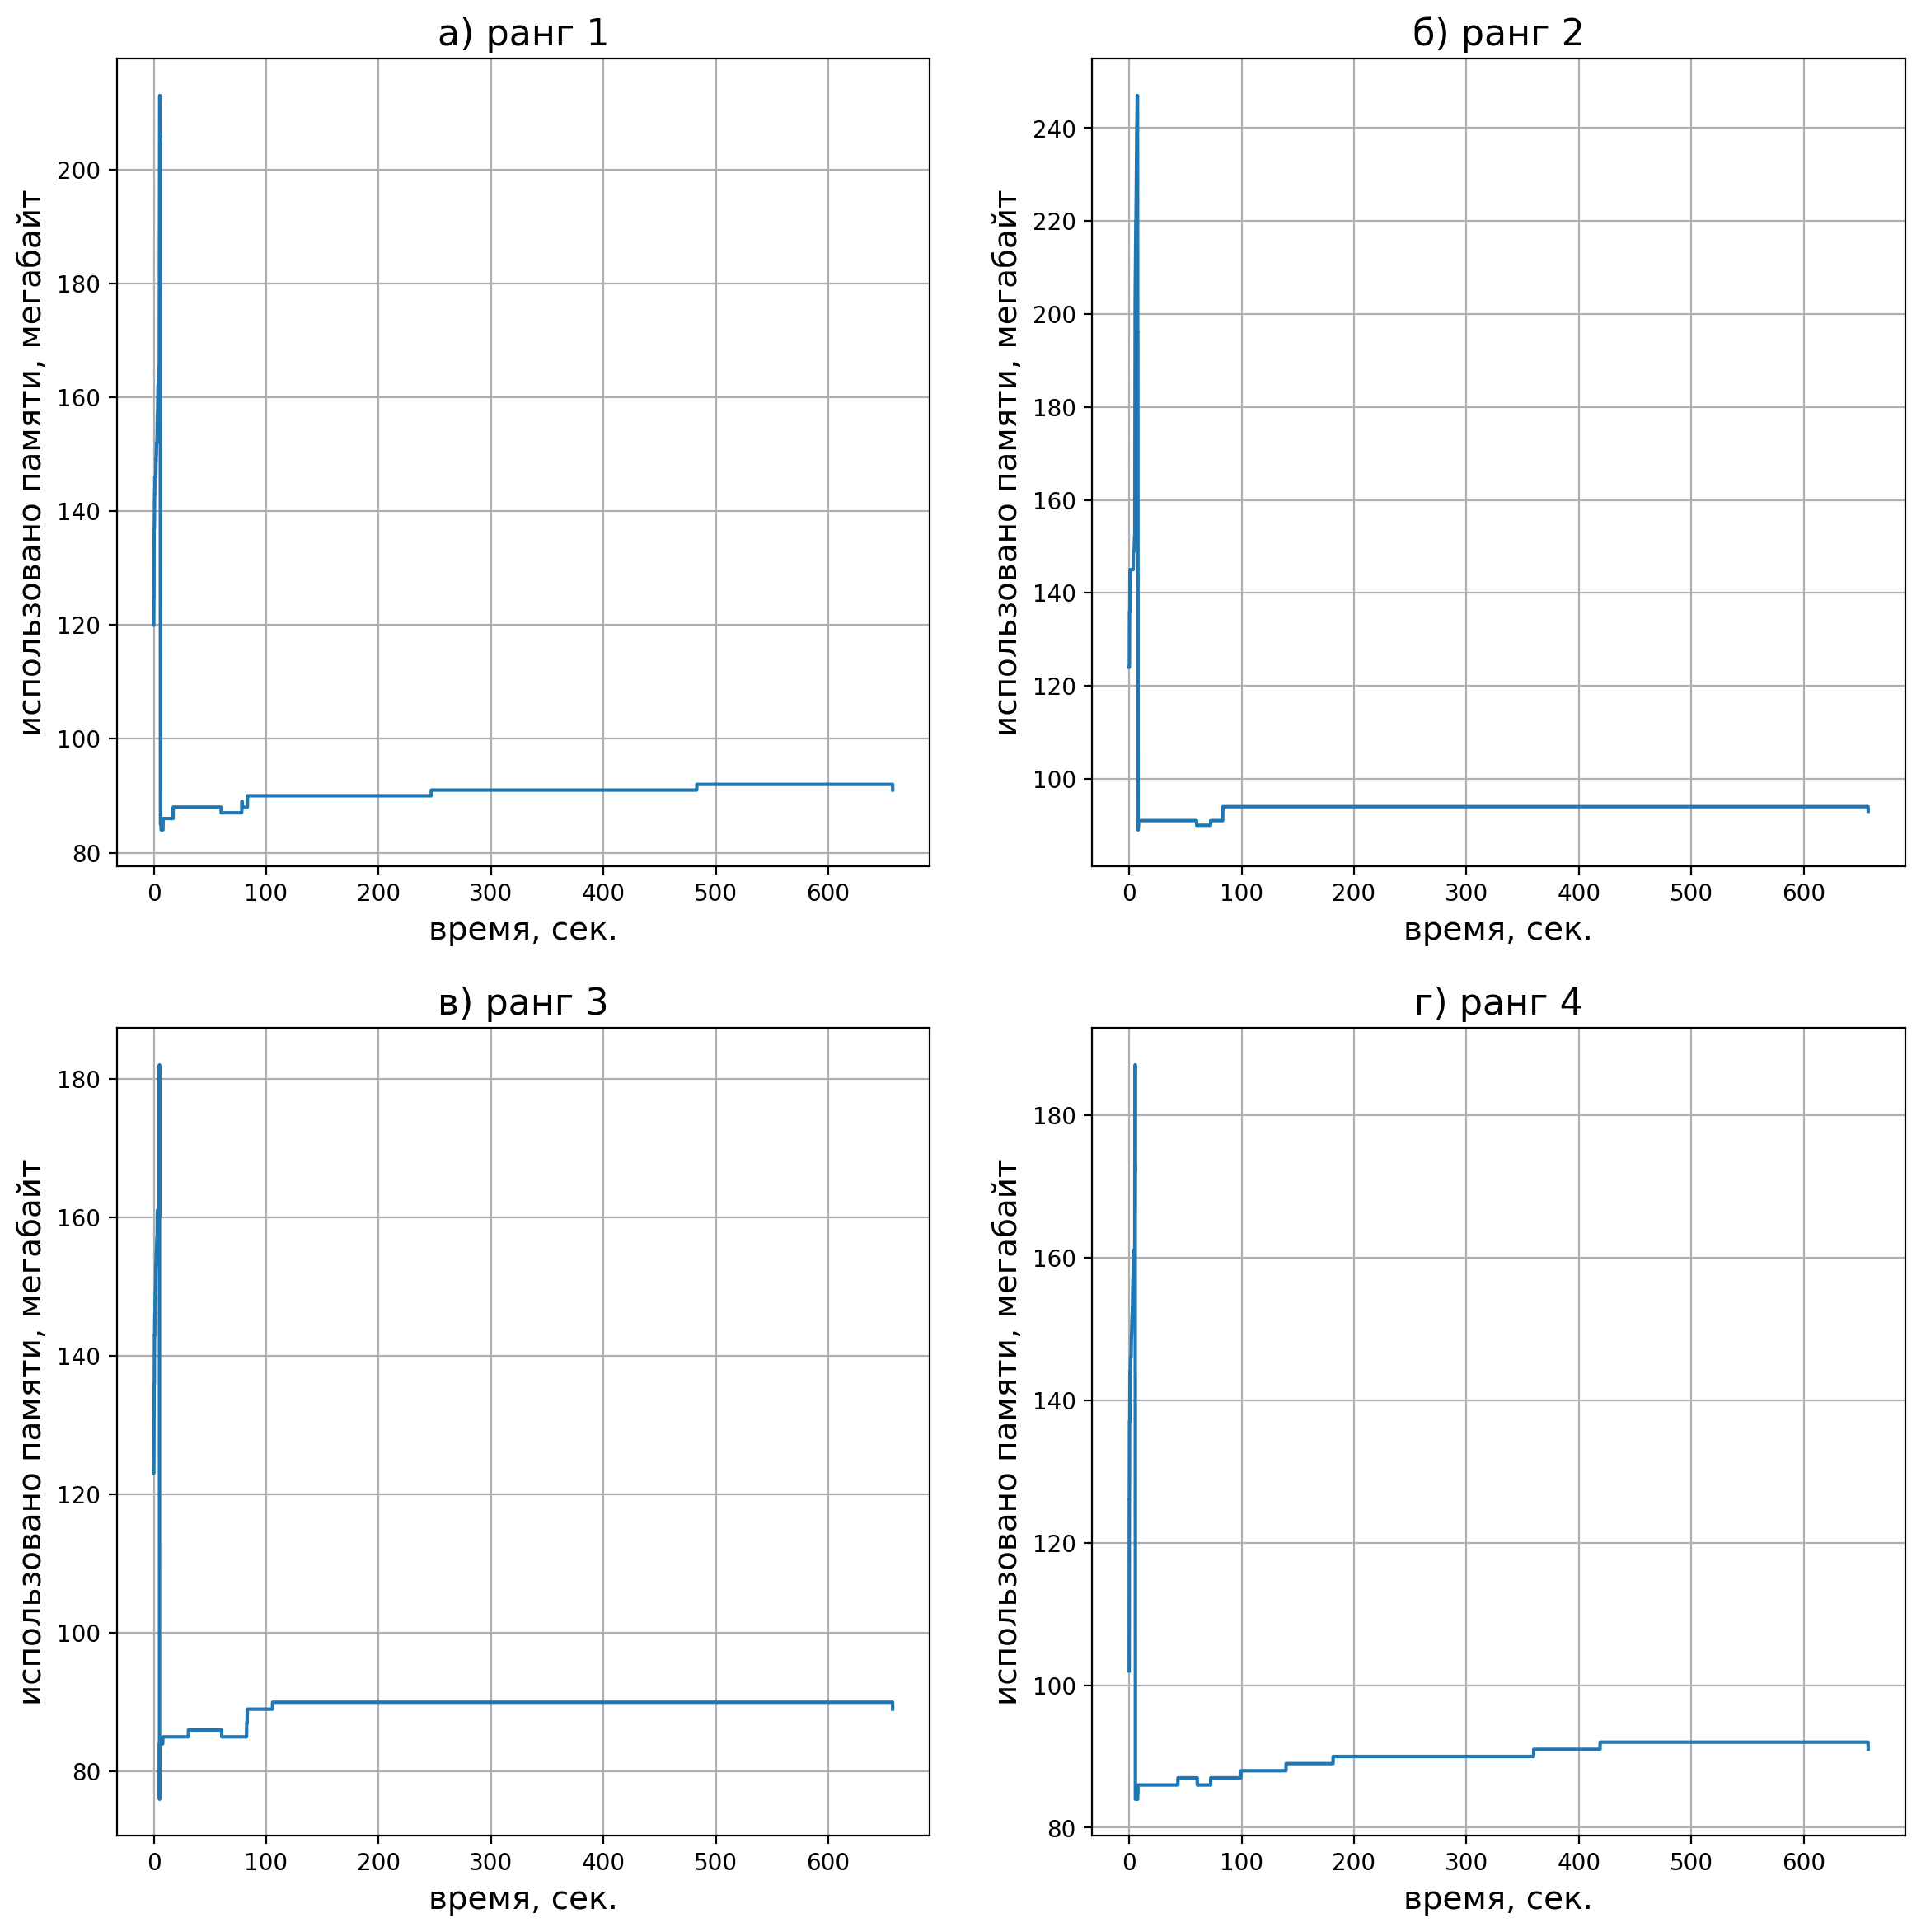

In [149]:
def memory_parser(filename):
    memdf = pd.read_csv(
        filename,
        index_col=0,
        header = 0,
#         skiprows = lambda i: i%5 != 0,
    )
    
    # ограничиваем по времени работы алгоритма
#     memdf = memdf[(memdf.index >= TMIN) & (memdf.index <= TMAX)]

    memdf = memdf.rename(
        dict([(pid, f'ранг {i+1}') for i, pid in enumerate(memdf.columns)]), 
        axis=1
    )

    return memdf, memdf.max(axis=0).max(), memdf.mean(axis=1).mean()


def memory_plot(memdf, title = ''):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 14), dpi=200)
    fig.suptitle(title, fontsize=16)
    
    x = (memdf.index - memdf.index.min())/1000
    
    for i, colname in enumerate(memdf.columns):
        ax = axs[i//2][i%2]
#         x = memdf.index
        y = memdf[colname]
        ax.plot(x, y)
        ax.set_xlabel('время, сек.',fontsize=14)
        ax.set_ylabel('использовано памяти, мегабайт',fontsize=14)
#         ax.set_ylim([mem_min, mem_max])
        ax.set_title(
                f'{chr(ord("а")+i)}) ранг {i+1}',
                fontdict = {'fontsize':16} 
            )
        ax.grid()
    plt.plot()
    
memlog, mem_max, mem_avg = memory_parser("mem.csv")
# memlog
memory_plot(memlog)

In [128]:
def log_parser(filename):
    global TMIN, TMAX
#     logdf = pd.read_csv(
#         filename,
#         names=['timestamp', 'rank', 'iter', 'step', 'action'],
#         sep=' ',
#         skiprows = lambda i: i%SKIP_LOG != 0
#     )
    logdf = LOGDF
    
    TMIN, TMAX = logdf['timestamp'].min(), logdf['timestamp'].max() 
    print('actions', logdf['action'].unique())
    
    # разбили по (итерация, шаг, ранк)
    step_groups = logdf.groupby(['iter', 'step', 'rank'])
    keys =sorted(
        step_groups.groups.keys(), 
    )
    blocks = [step_groups.get_group(key).drop(['iter', 'step', 'rank'], axis=1) for key in keys]
    
    blocks = [
        {'iter': key[0], 'step': key[1], 'phase': (key[0], key[1]), 'rank': key[2], 'log': block} for key, block in zip(keys, blocks)
    ]
    
    return blocks, (logdf['timestamp'].max() - logdf['timestamp'].min())/1000

def parse_log_simple(filename):
    logdf = pd.read_csv(
        filename,
        names=['timestamp', 'rank', 'iter', 'step', 'action'],
        sep=' ',
        skiprows = lambda i: i%SKIP_LOG != 0
    )
    
    return logdf, (logdf['timestamp'].max() - logdf['timestamp'].min())/1000, len(logdf['iter'].unique())

def make_cumsum(block):
    stepdf = block['log']
    
    stepdf = stepdf.reset_index().drop(['index'], axis=1)
    # переходим в one-hot
    stepdf = pd.concat(
        [stepdf, pd.get_dummies(stepdf['action'], dtype=int)], axis=1
    )
    action_types = stepdf['action'].unique()
    stepdf = stepdf.drop(['action'], axis=1)
    
    for at in action_types:
        stepdf[at] = stepdf[at].cumsum()  
    
    block['log'] = stepdf
    return block

def rename_tags(x):
    if x[0] == 's':
        return f'отправка метки {x[-1]}'
    return f'прием метки {x[-1]}'


def plot_unique_step(blocks): 
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 14), dpi=200)
#     fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 4), dpi=100)
    
    cols_to_plot = list(filter(lambda x: x.startswith('send') or x.startswith('recv'), blocks[0]['log'].columns))
    cols_to_plot = sorted(cols_to_plot, key = lambda x: x[::-1])
    
    
    # ищем минимальные границы
    tmin = min([block['log']['timestamp'].min() for block in blocks])
    tmax = max([block['log']['timestamp'].max() for block in blocks])
    
    # перебираем узлы
    for i, block in enumerate(blocks):
        ax = axs[i//2][i%2]
#         ax = axs[i]
        # перебираем все виды действий
        for j, colname in enumerate(cols_to_plot):
            if colname not in block['log'].columns:
                continue
            x = np.linspace(0, (tmax-tmin), len(block['log']), True)/1000
            y = block['log'][colname]
            ax.plot(x, y, label=rename_tags(colname) )
            ax.set_ylabel('действий, тыс.',fontsize=14)
            ax.set_xlabel('время, сек.',fontsize=14)
            ax.grid(True)
            ax.legend()
            ax.set_title(
                f'{chr(ord("а")+i)}) ранг {block["rank"]}',
                fontdict = {'fontsize':16} 
            )
    plt.show()
    
def log_plot(blocks):
    # выделим (итерация, шаг)
    phases = set(map(lambda x: x['phase'], blocks))
    phases = sorted(phases)

    # сгруппируем блоки в группы по (итерация, шаг)
    per_phase_groups = [
        sorted(
            list(filter(
                lambda x: x['phase'] == phase, 
                blocks
            )), 
            key = lambda x: x['rank']
        )
        for phase in phases
    ]


    # выделим timestamp'ы начала этапов
    start_tss = list(map(lambda x: x[0]['log']['timestamp'].min(), per_phase_groups))
    finish_tss = list(map(lambda x: x[0]['log']['timestamp'].max(), per_phase_groups))
    print(len(per_phase_groups))
    # рисуем графики    
    for phase_blocks in per_phase_groups:
        cs_blocks = list(map(make_cumsum, phase_blocks))
        # отрисуем количество обработанных запросов
        plot_unique_step(cs_blocks)


# параметры

In [129]:
SKIP_MEM = 10000
SKIP_LOG = 1000

MODE = MODE2

In [130]:
# LOGDF = pd.read_csv(
#         "log.txt",
#         names=['timestamp', 'rank', 'iter', 'step', 'action'],
#         sep=' ',
#         skiprows = lambda i: i%SKIP_LOG != 0
#     )

actions ['send_tag_1' 'send_tag_2' 'send_tag_4' 'recv_tag_4' 'send_tag_3'
 'recv_tag_3']
48
12


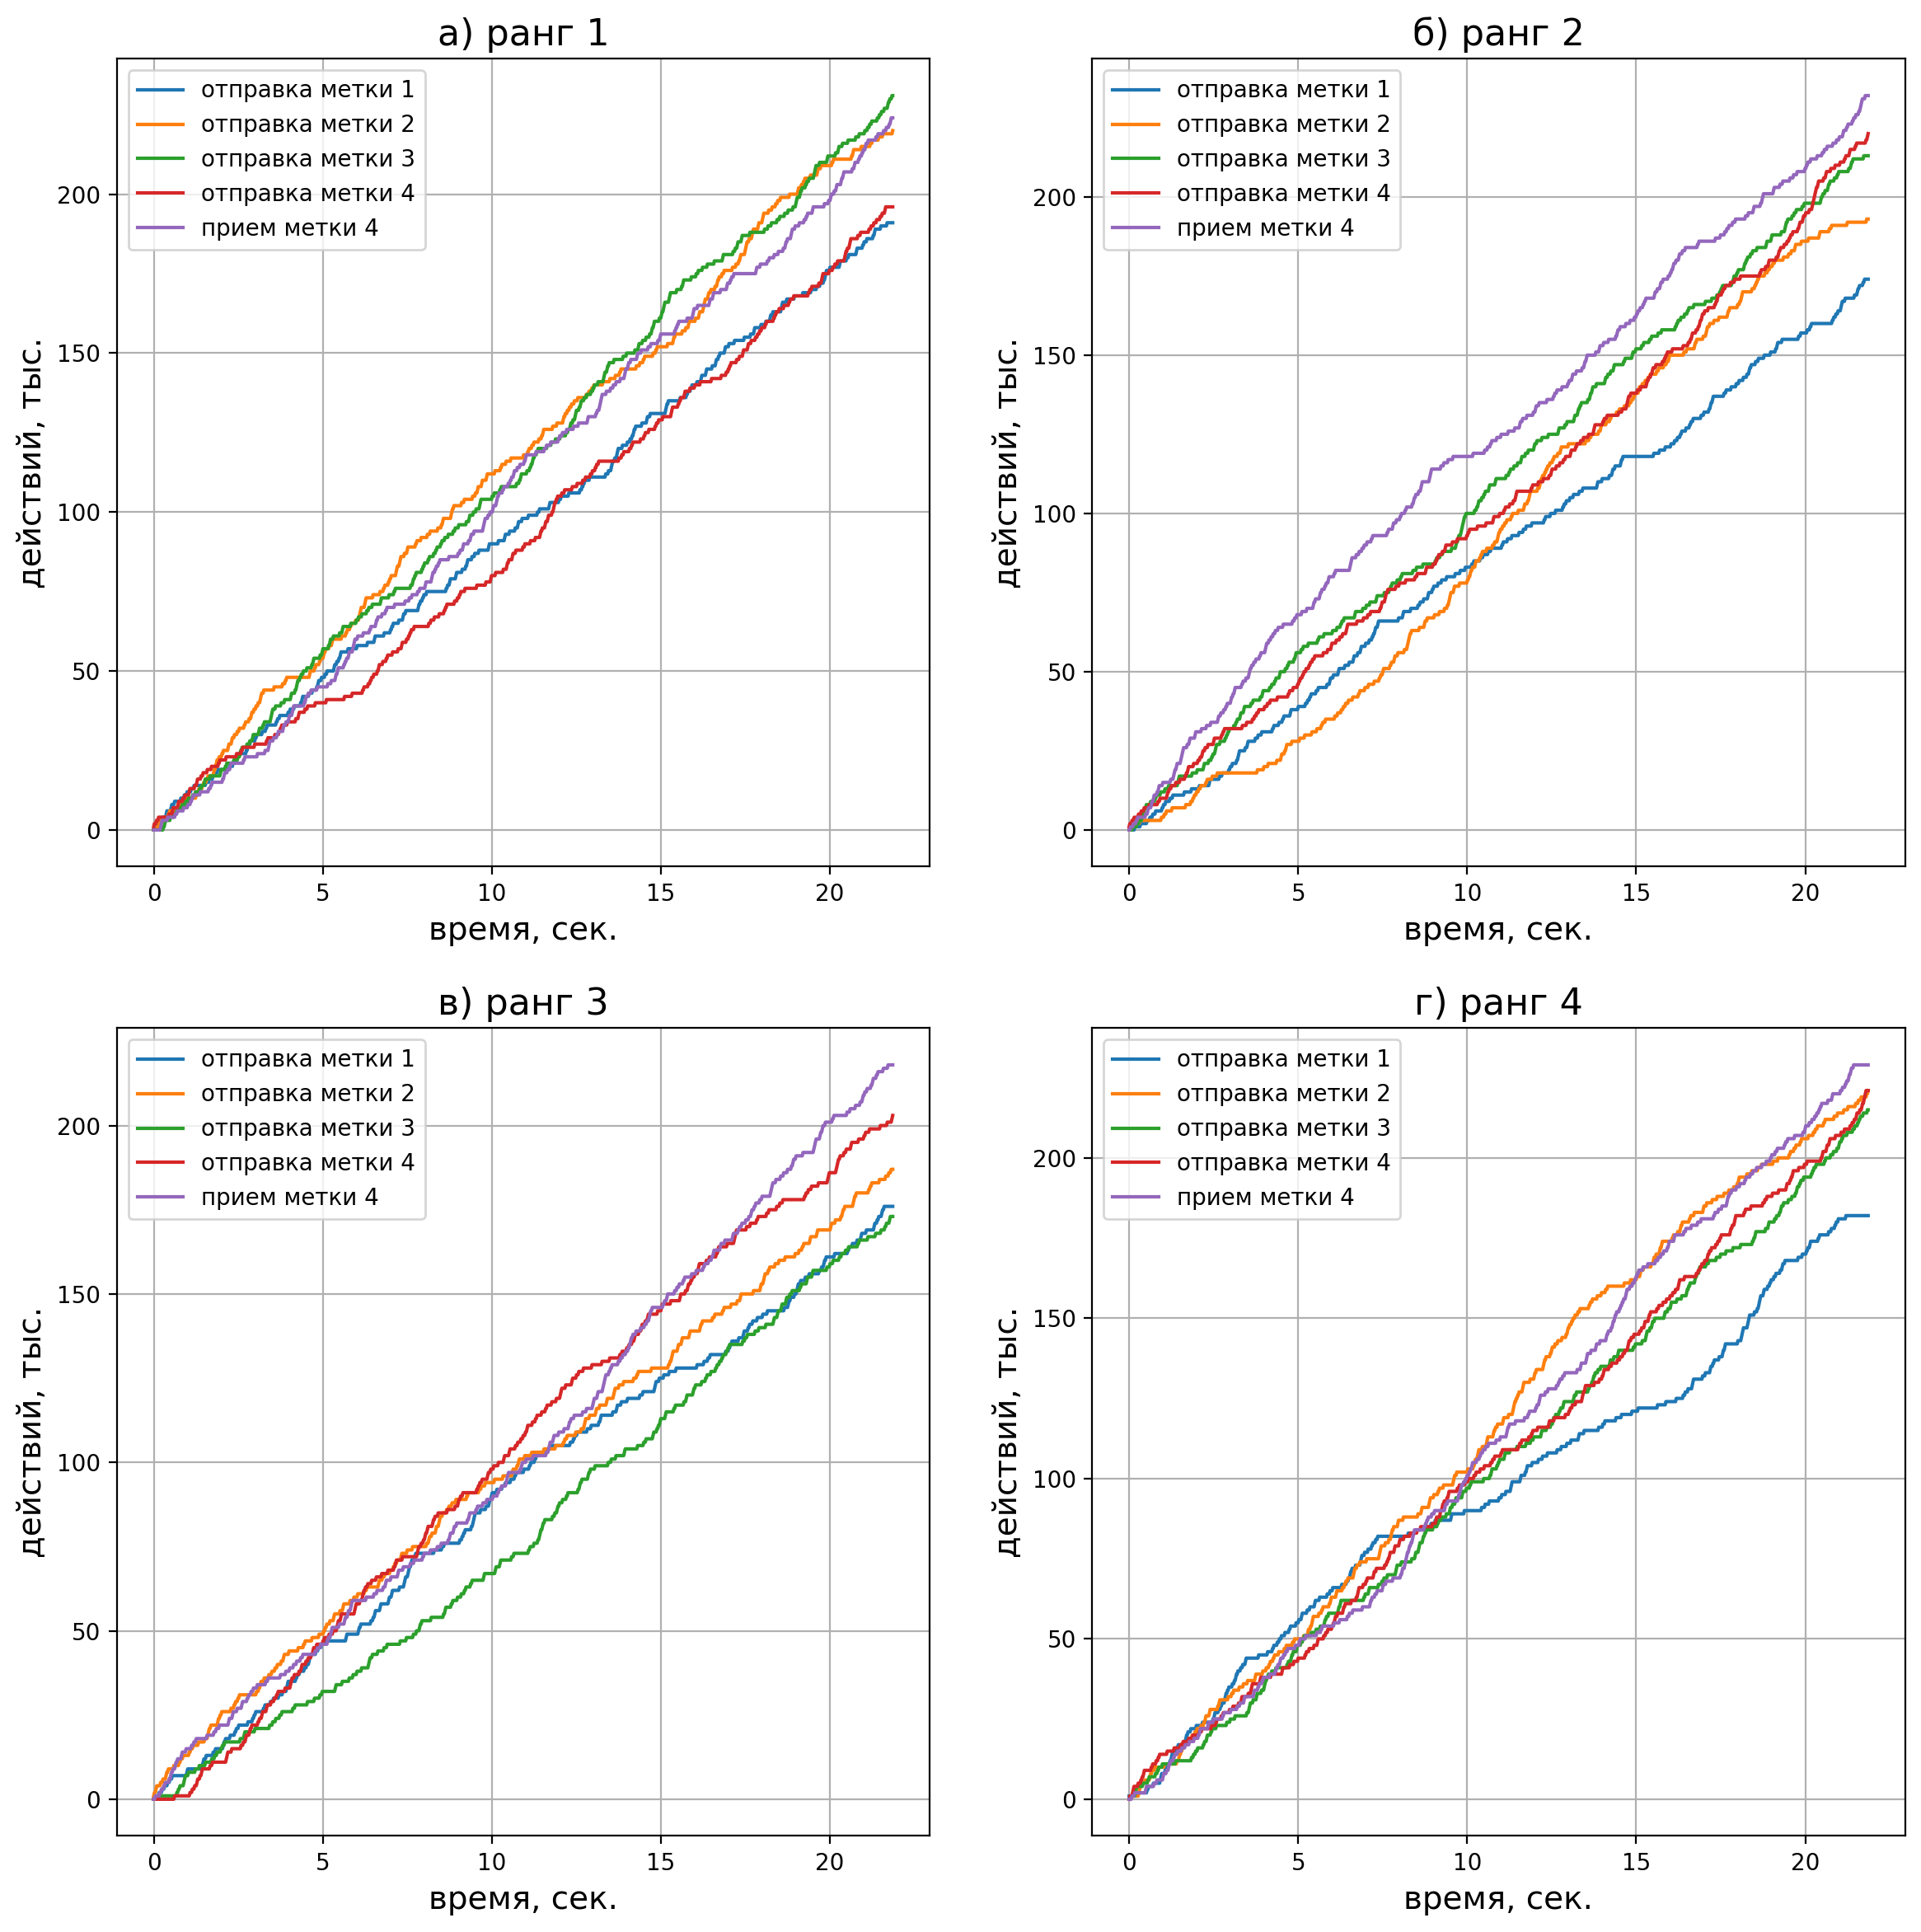

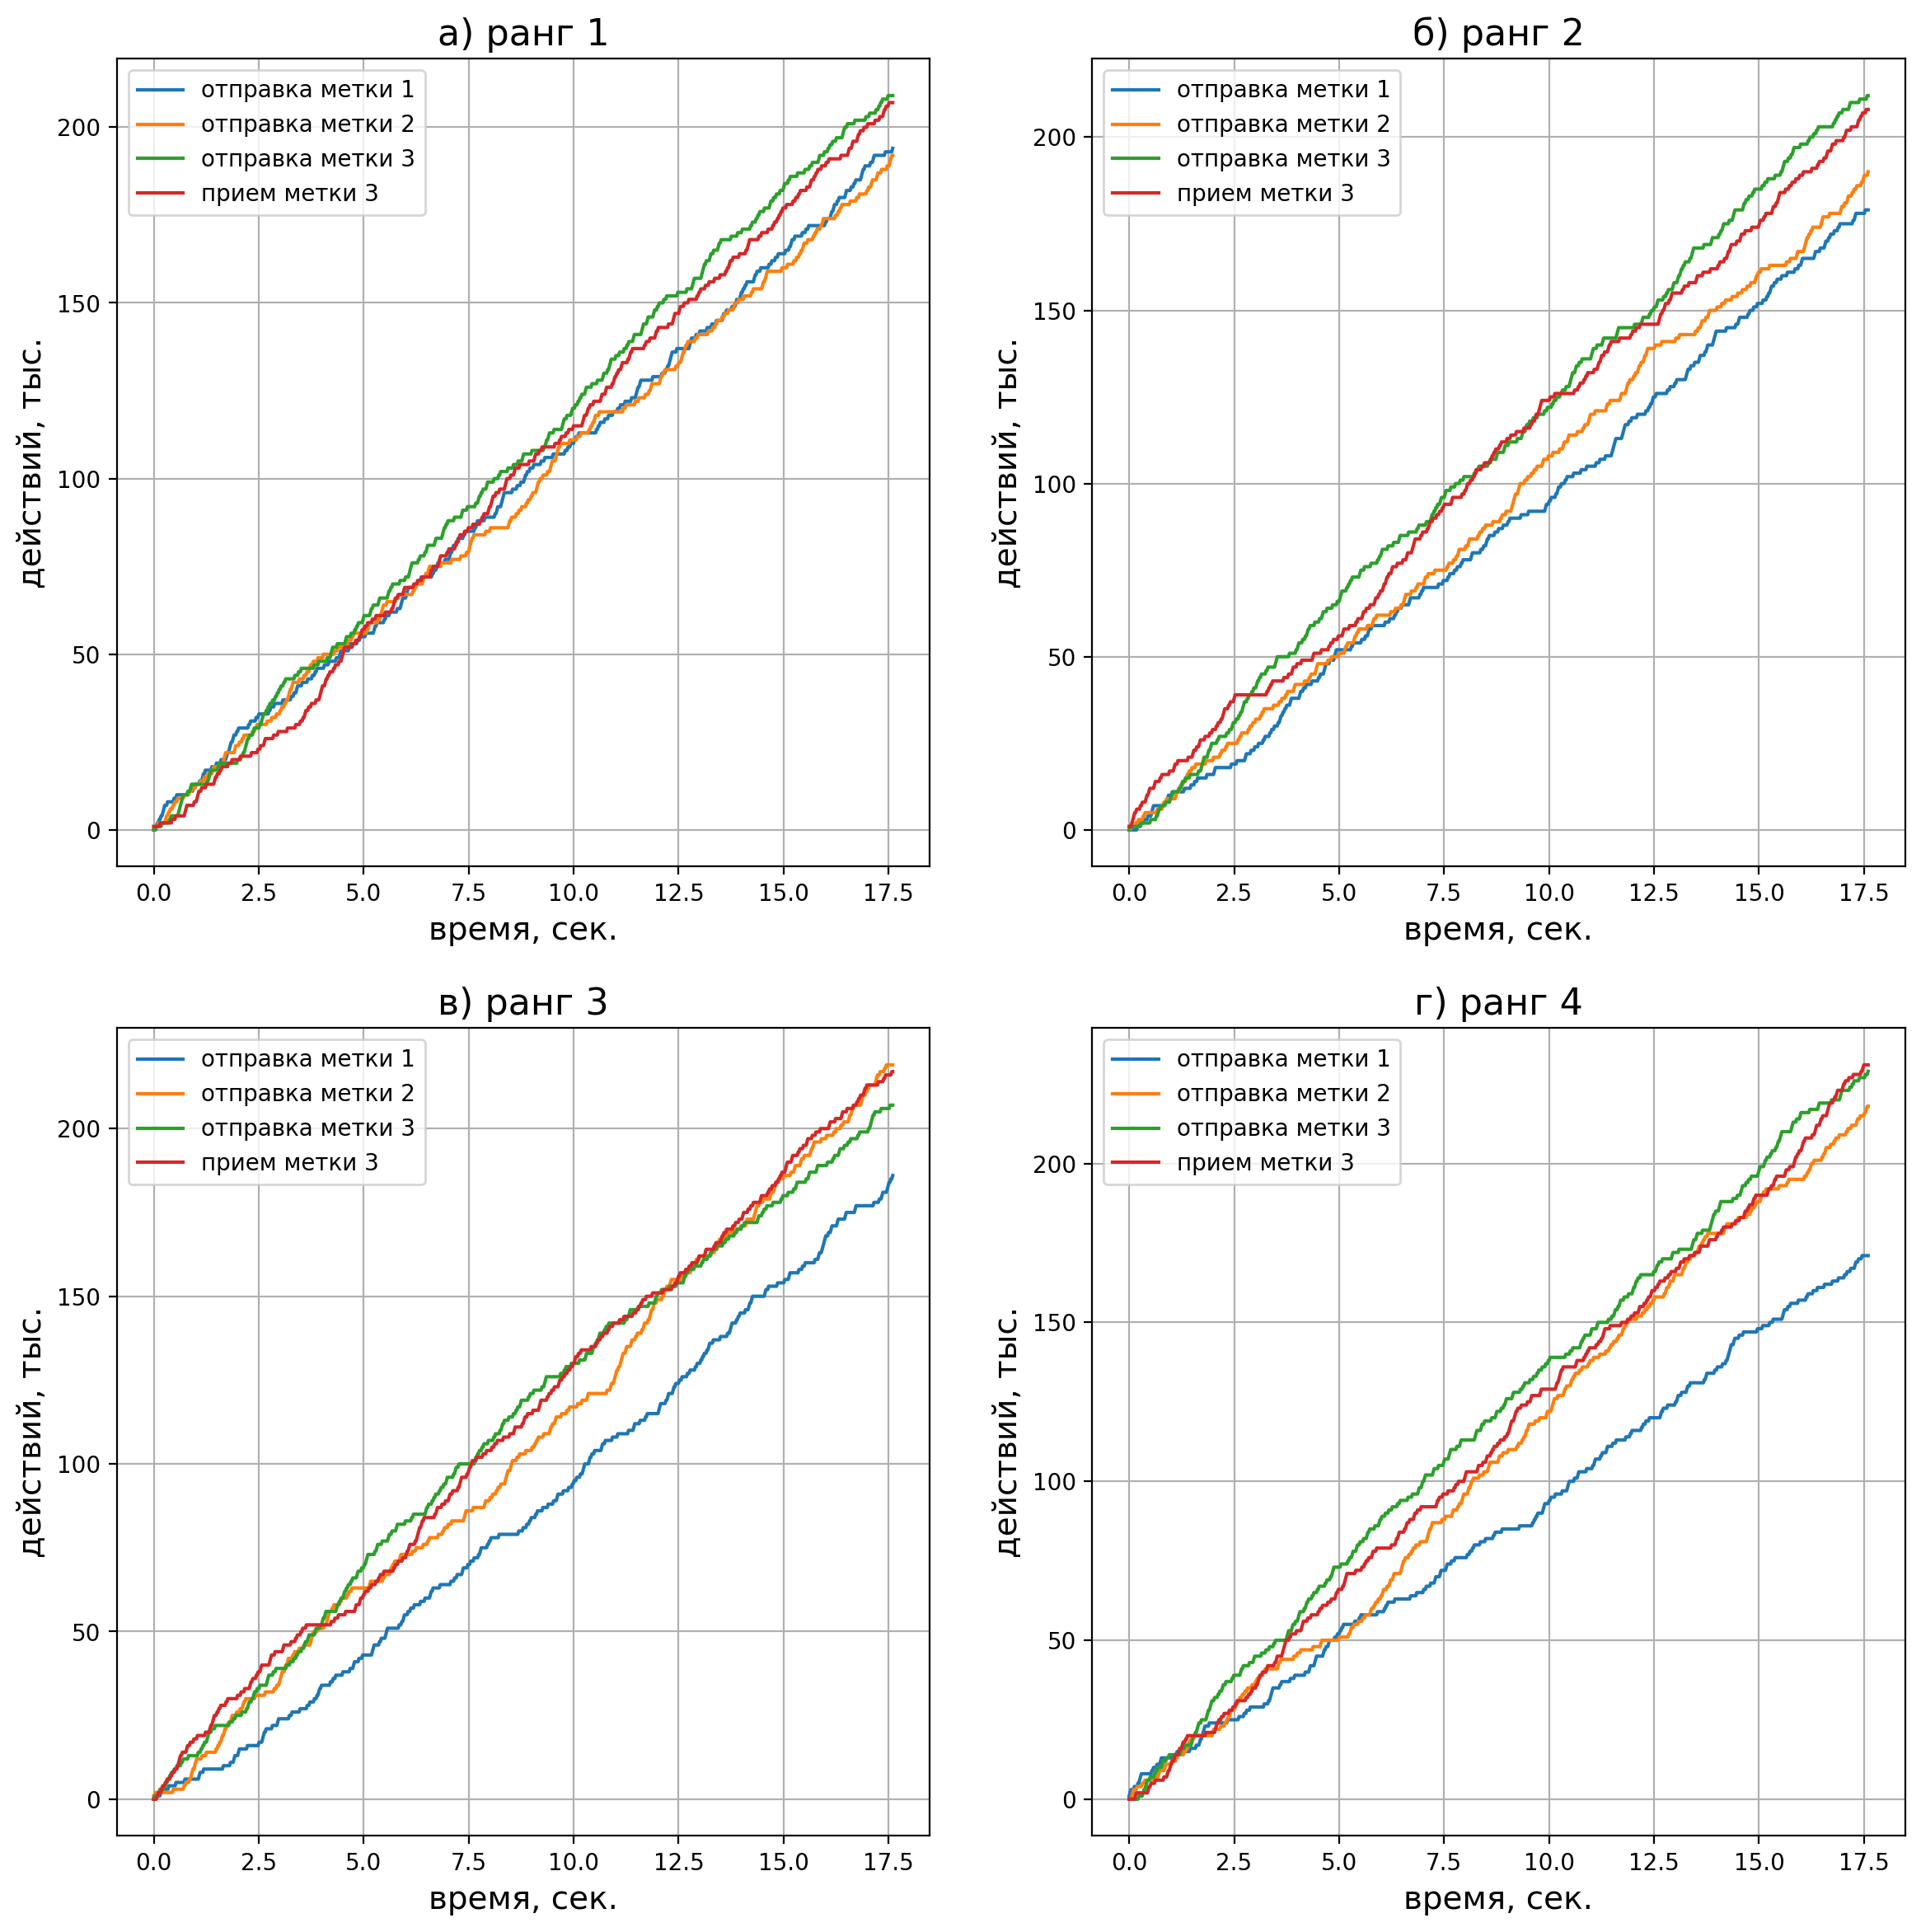

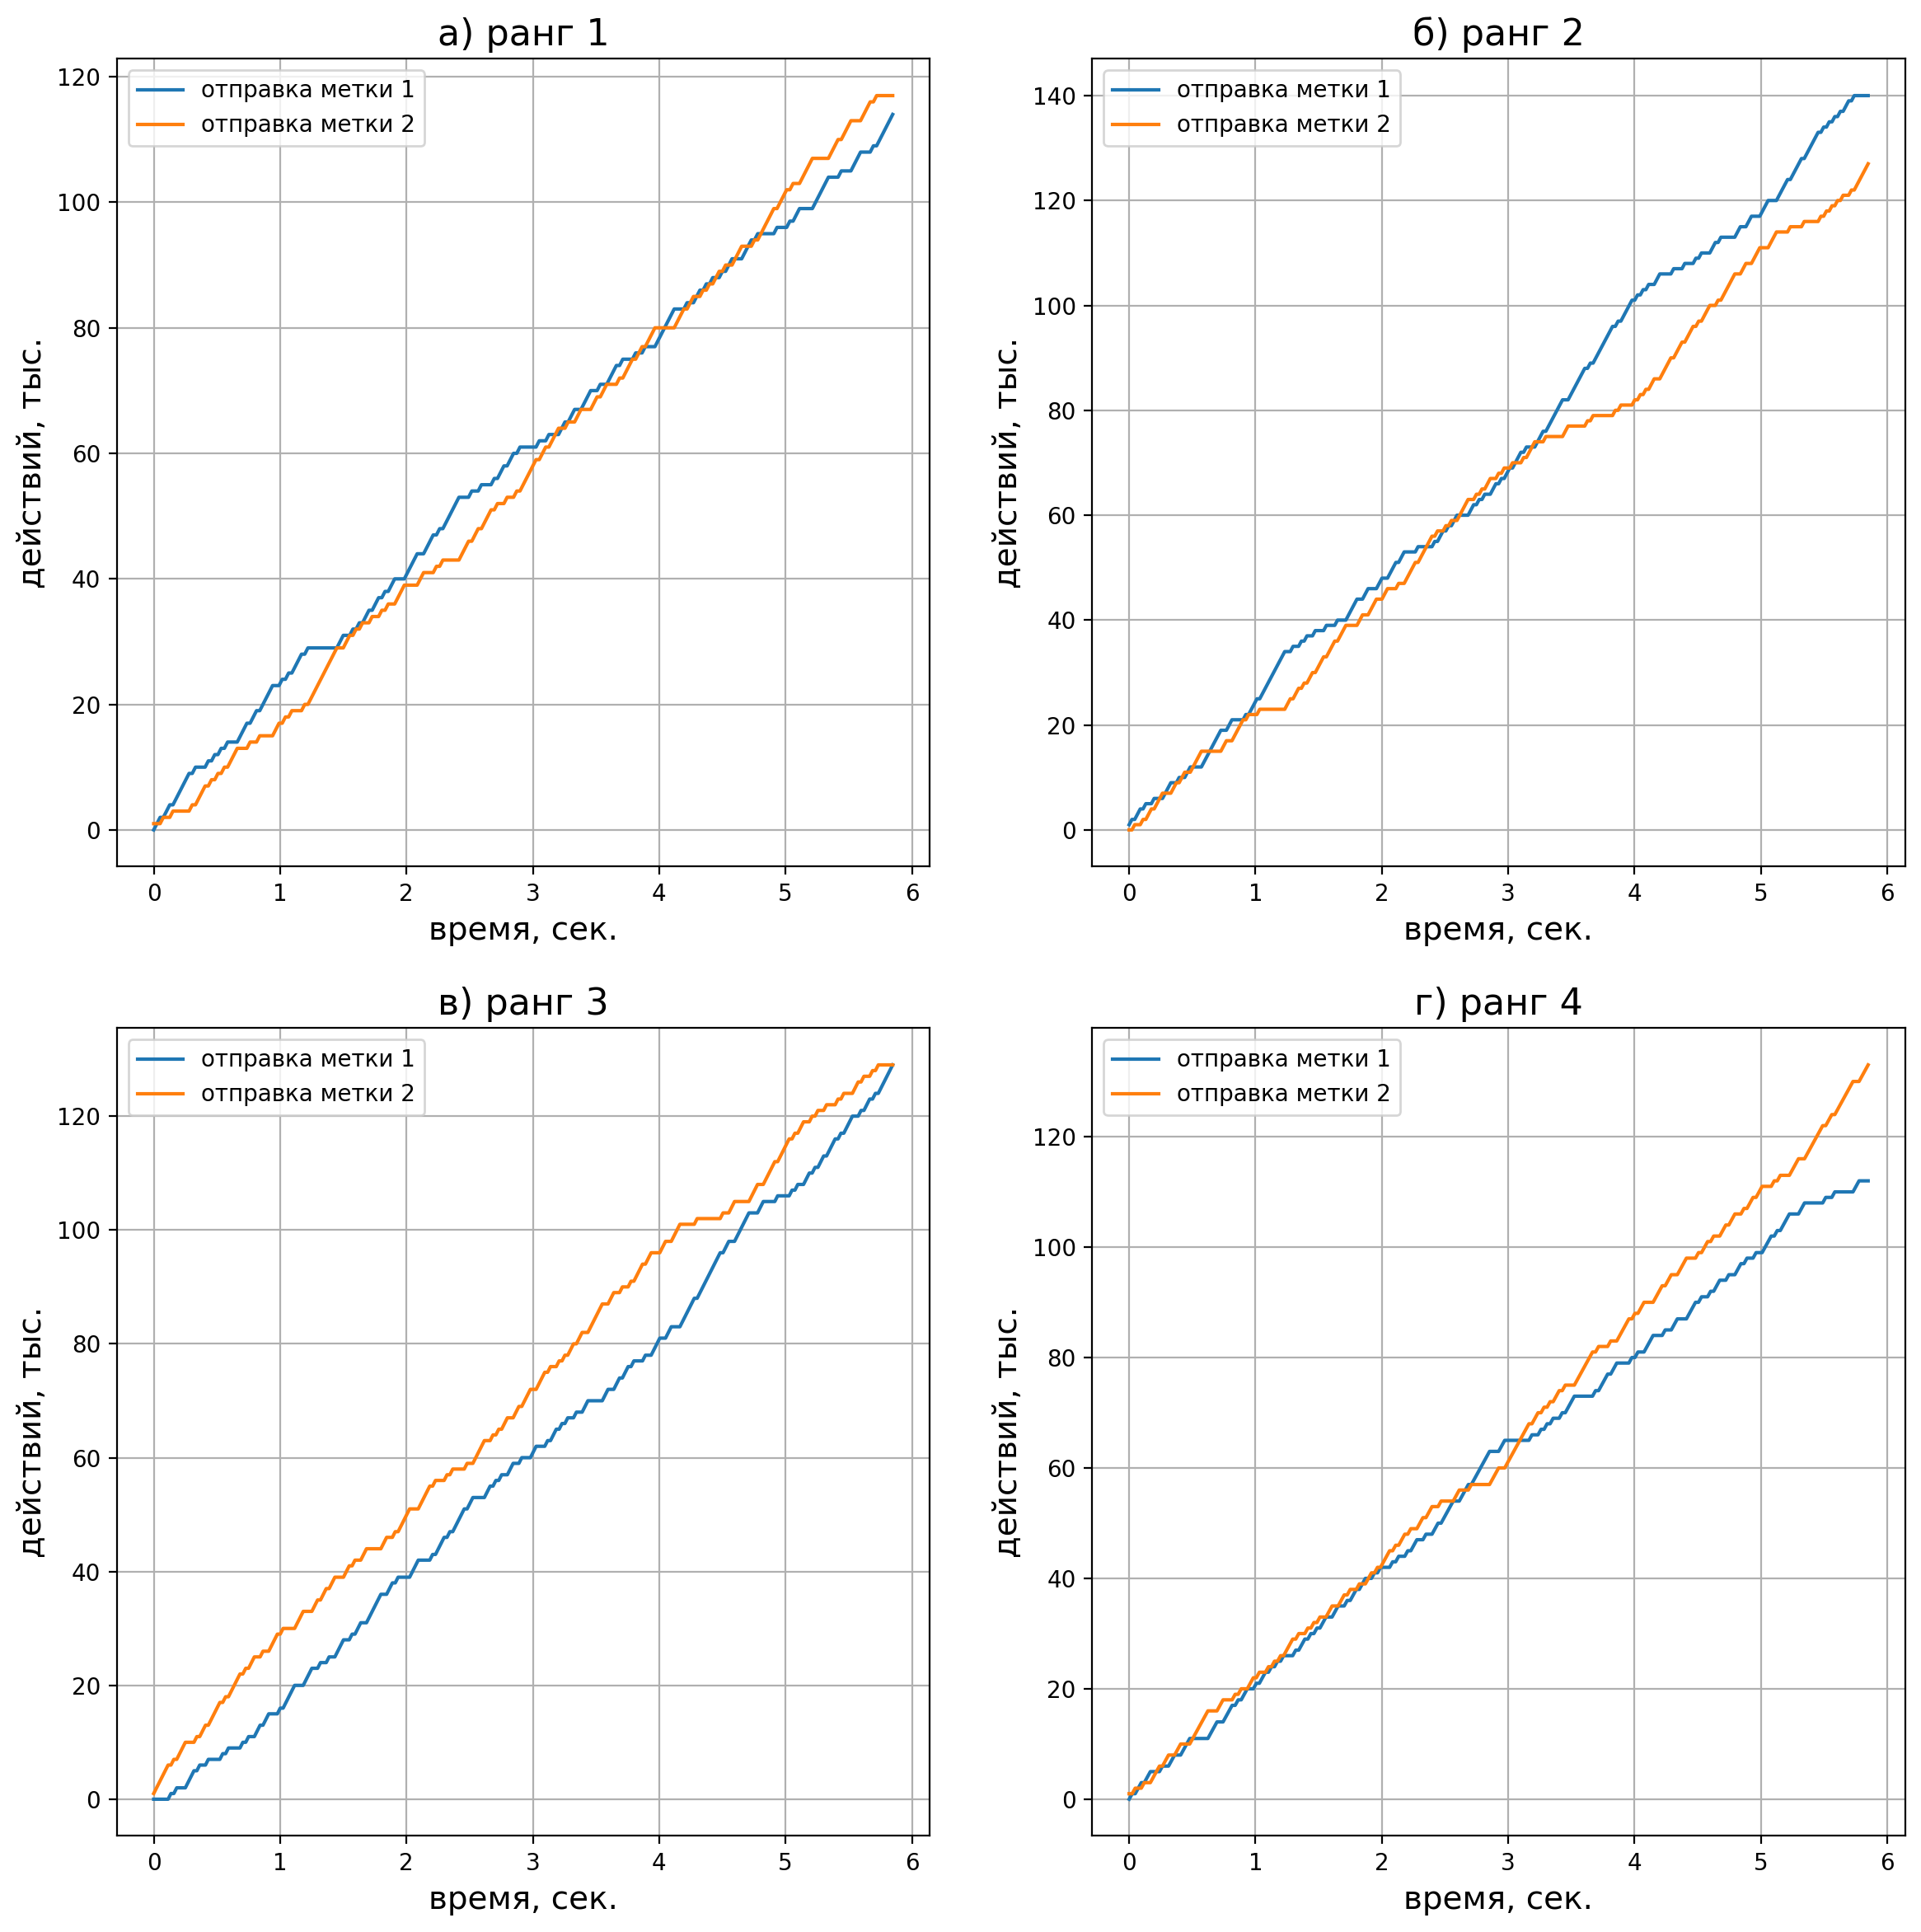

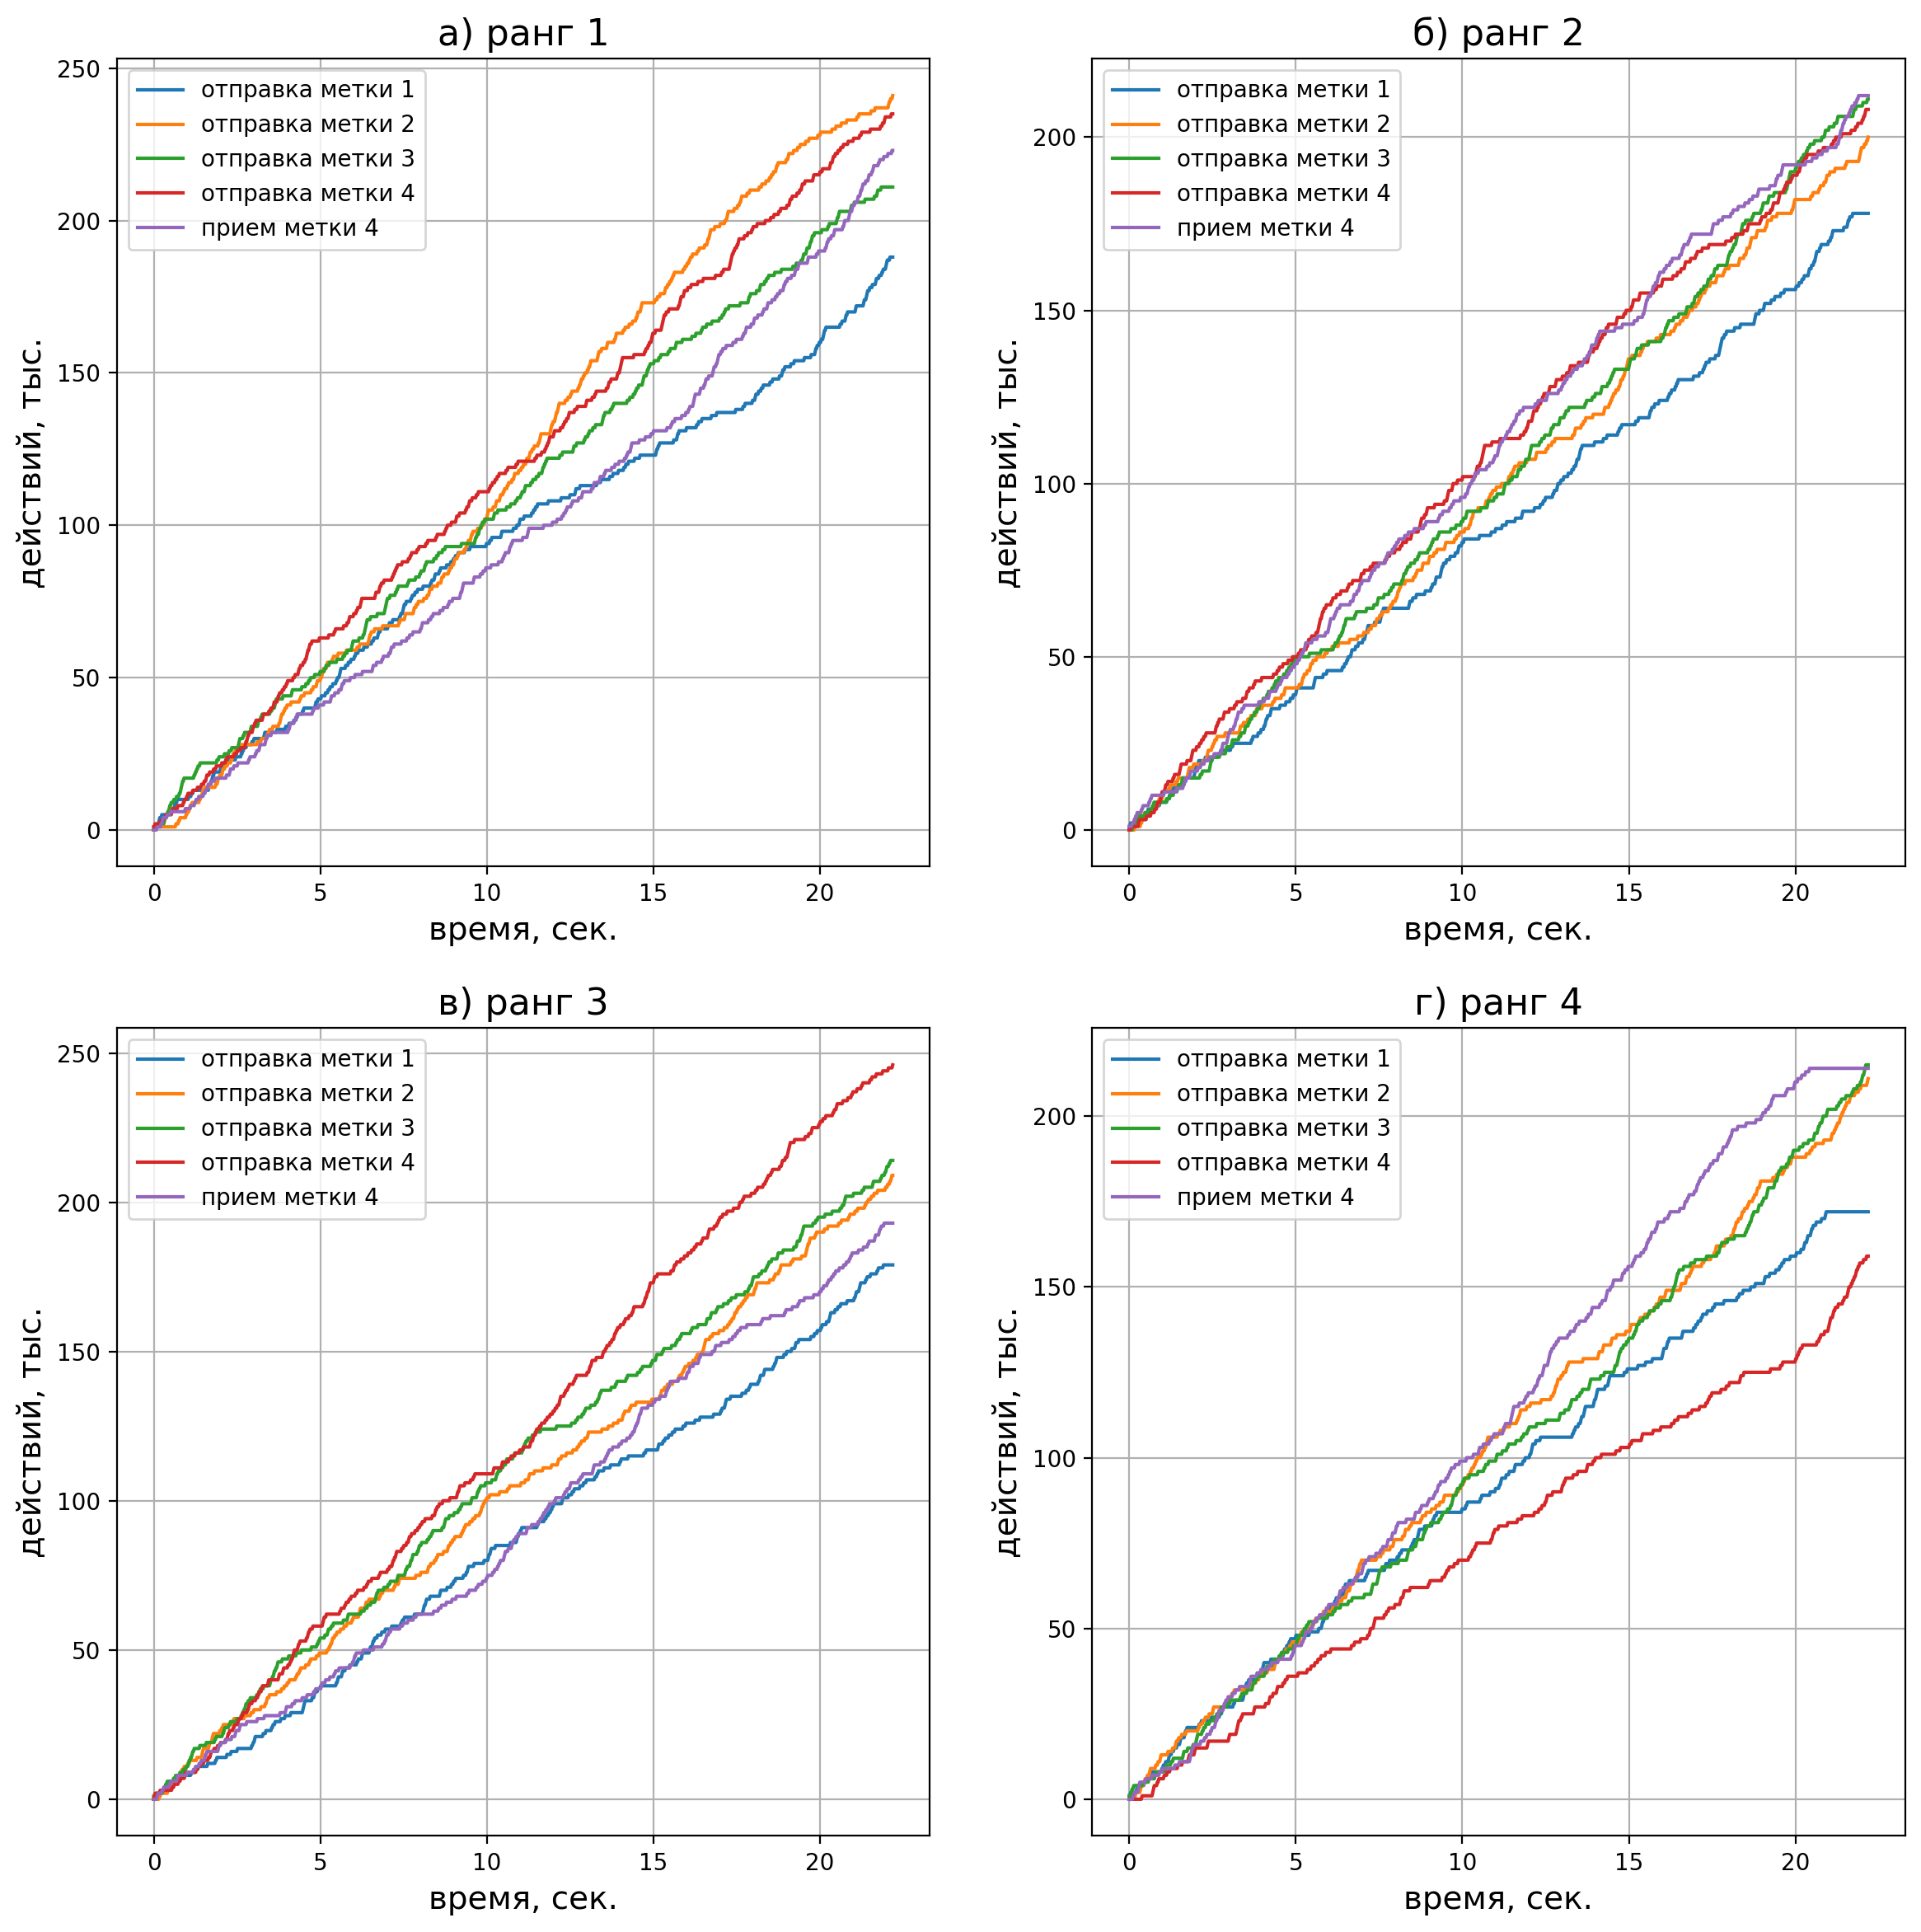

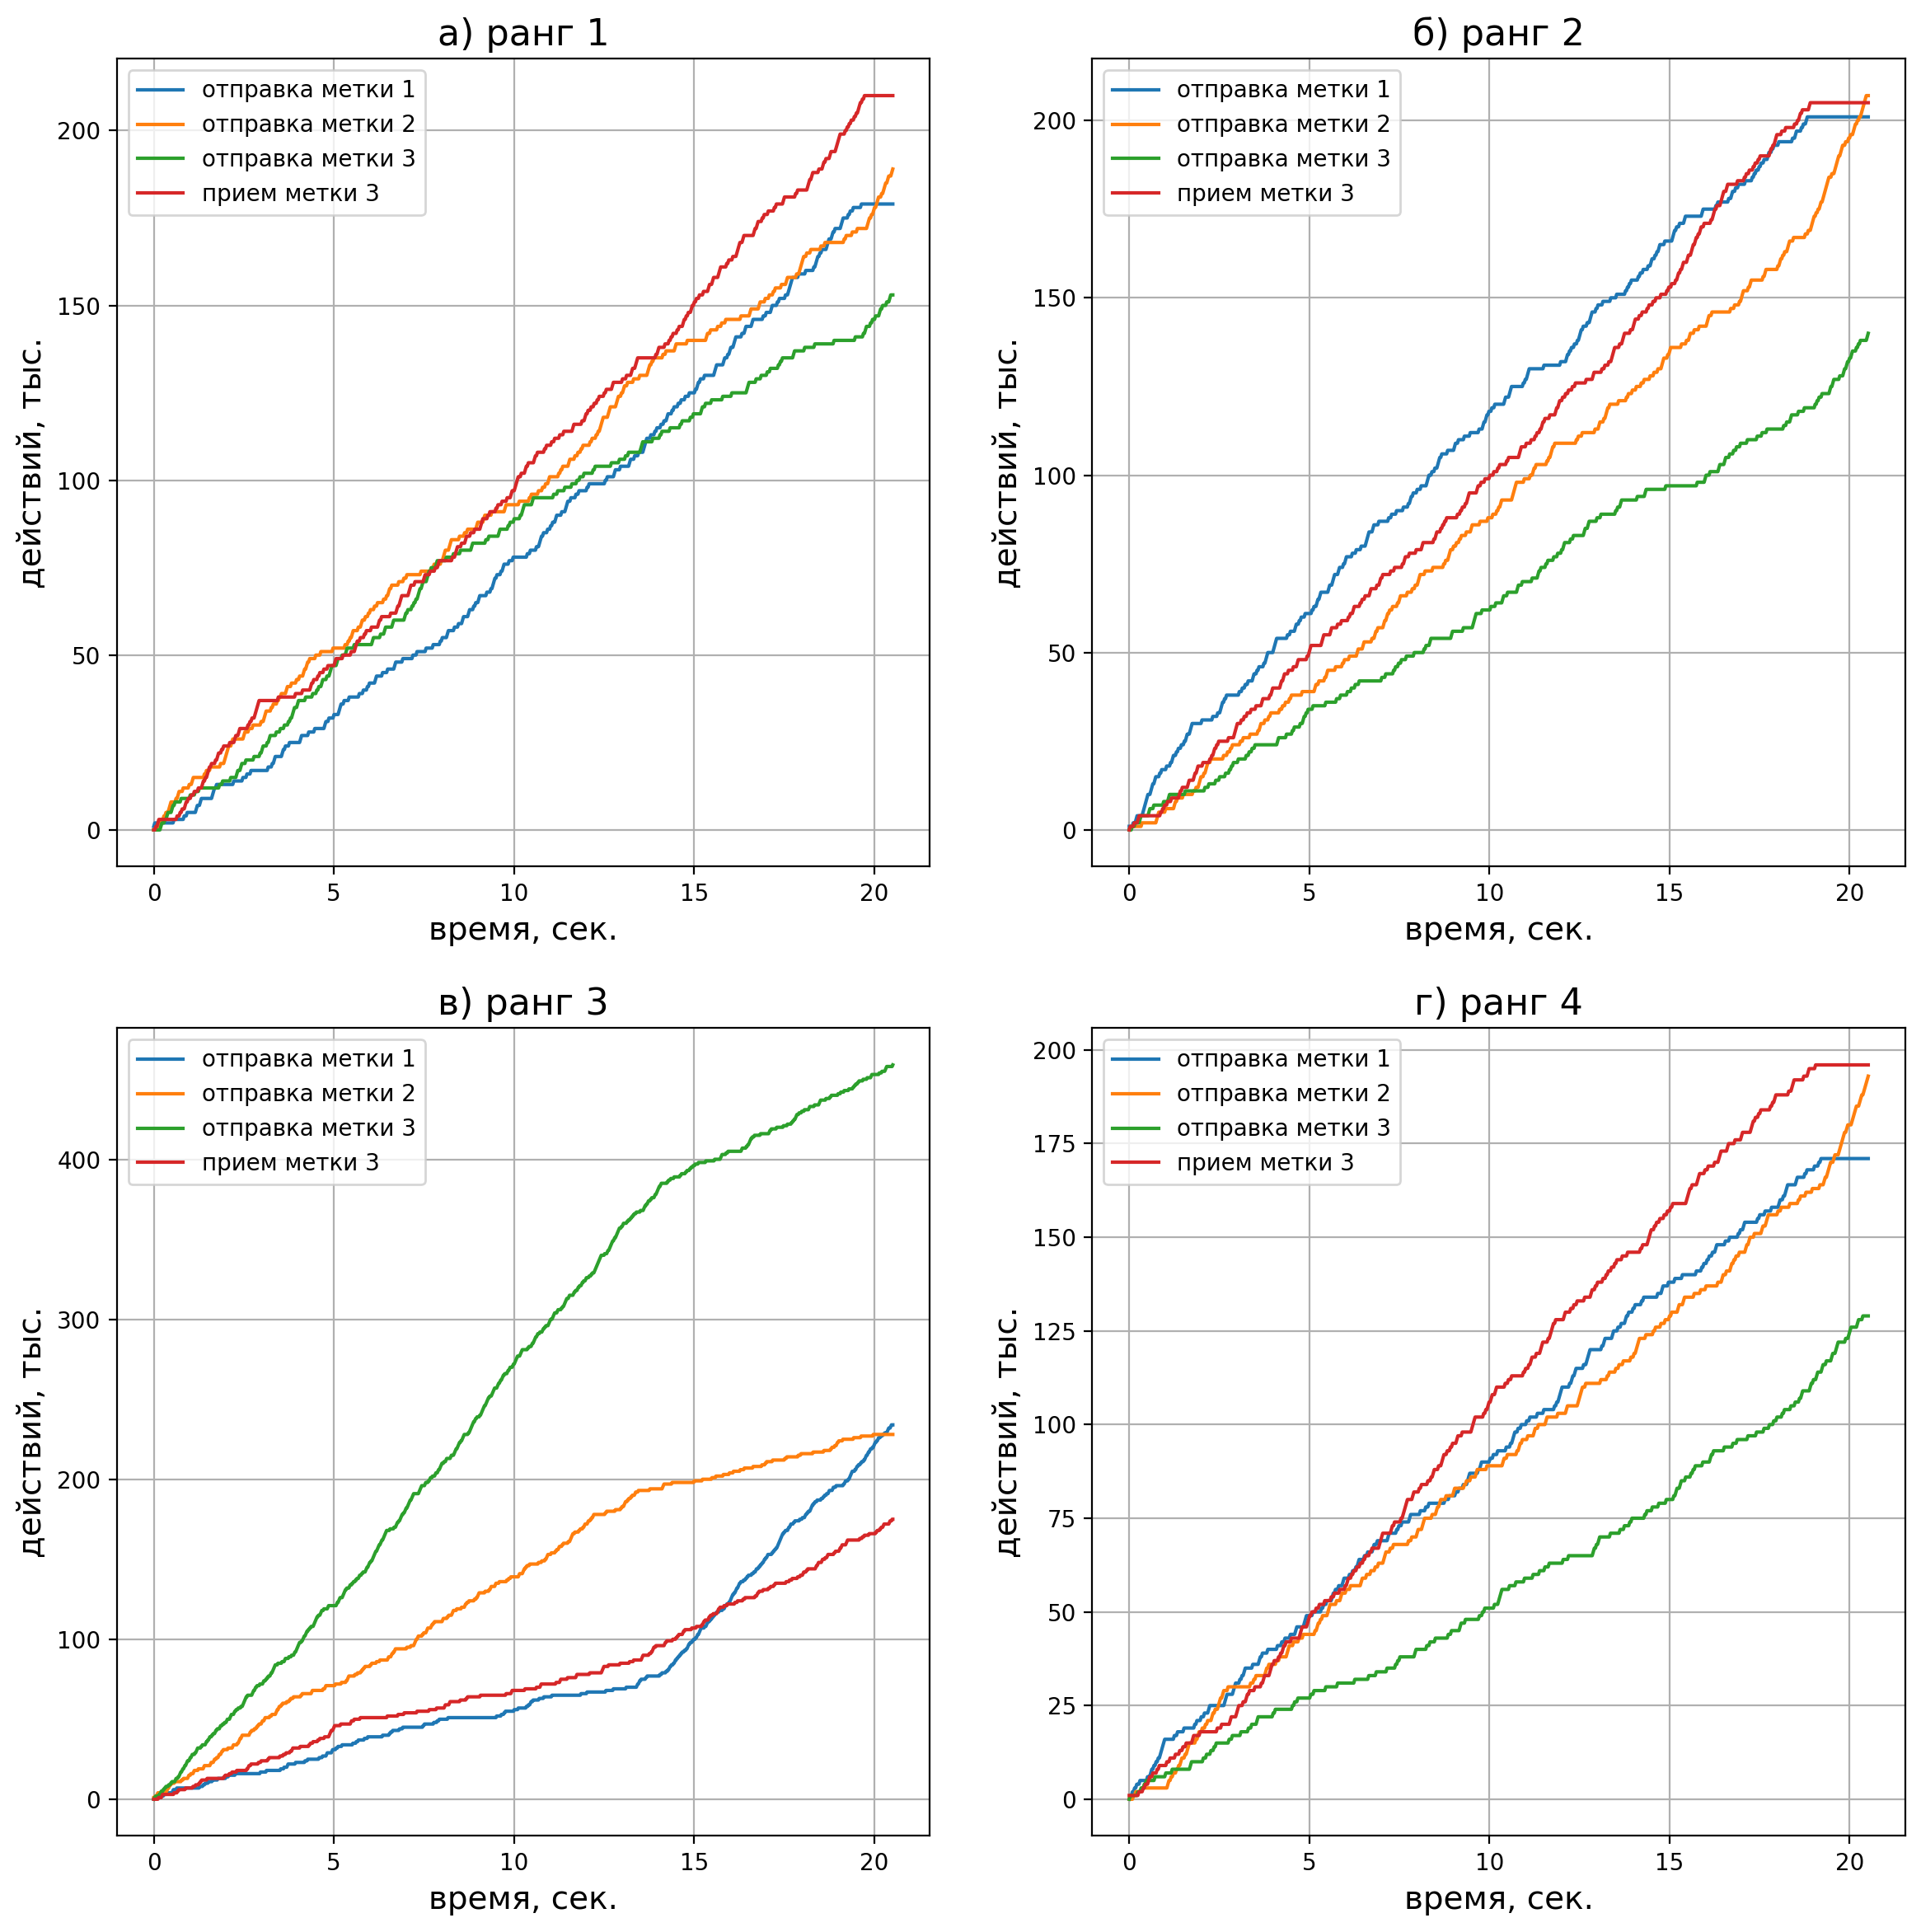

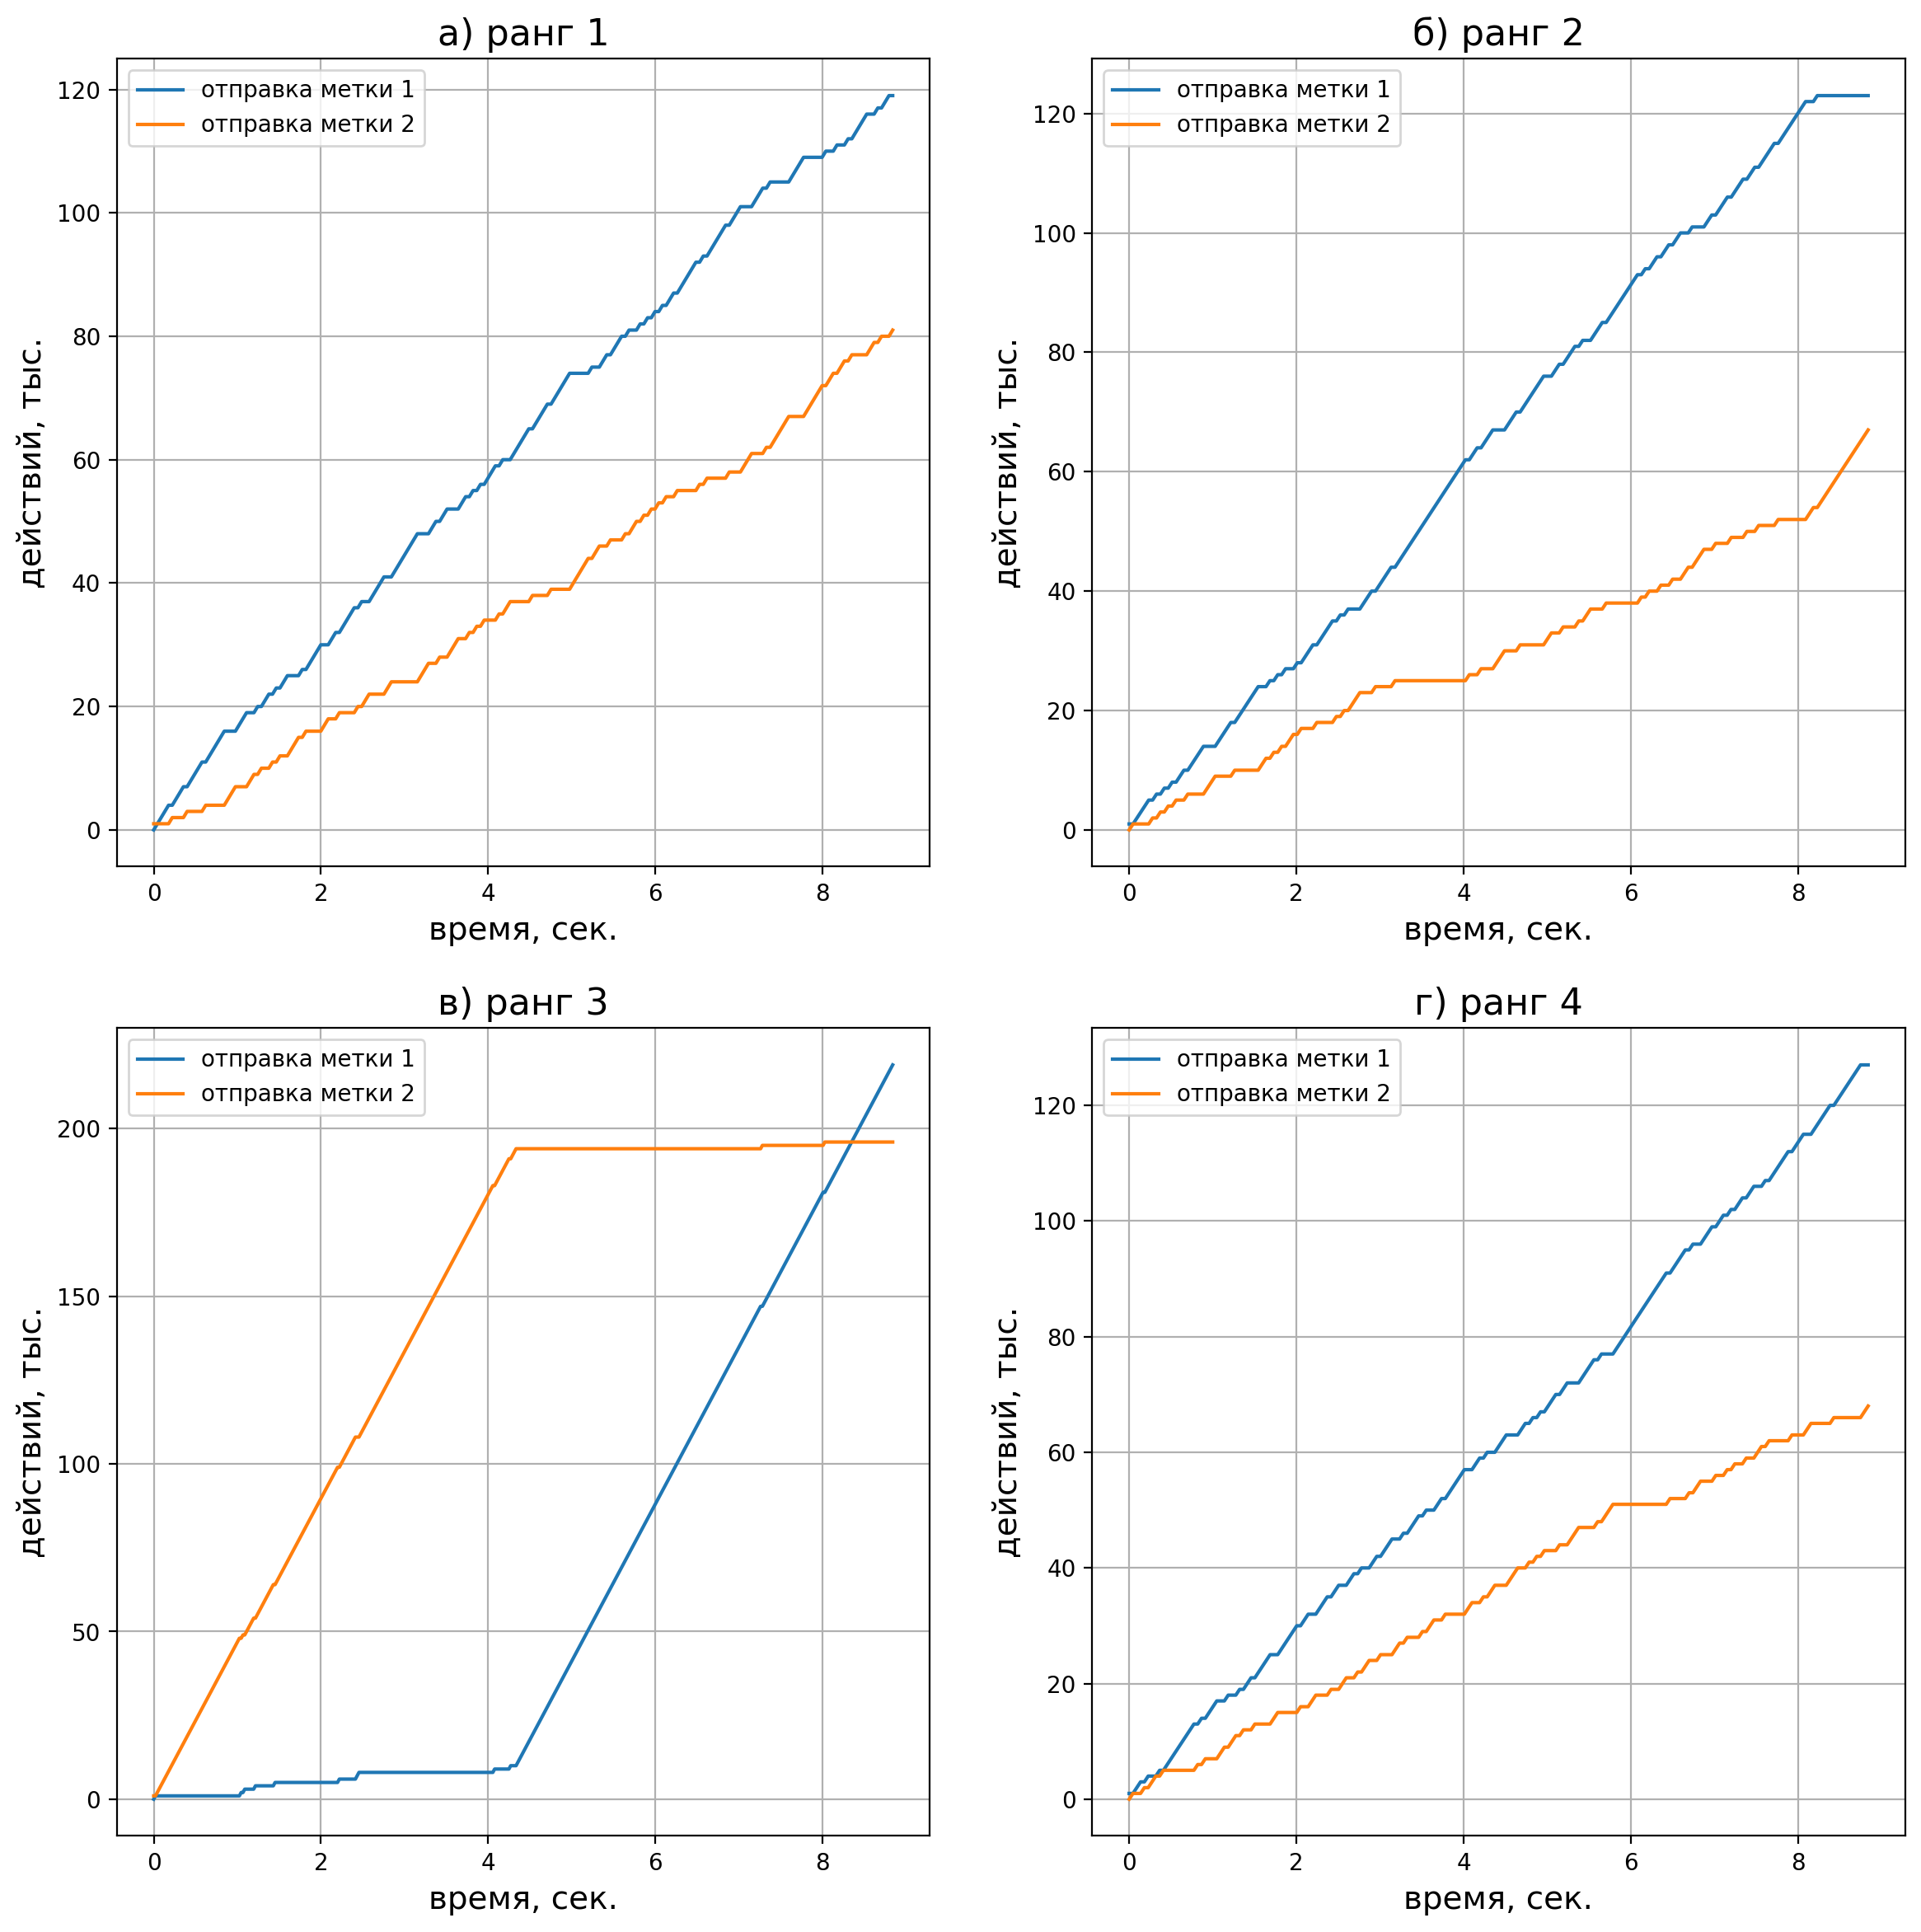

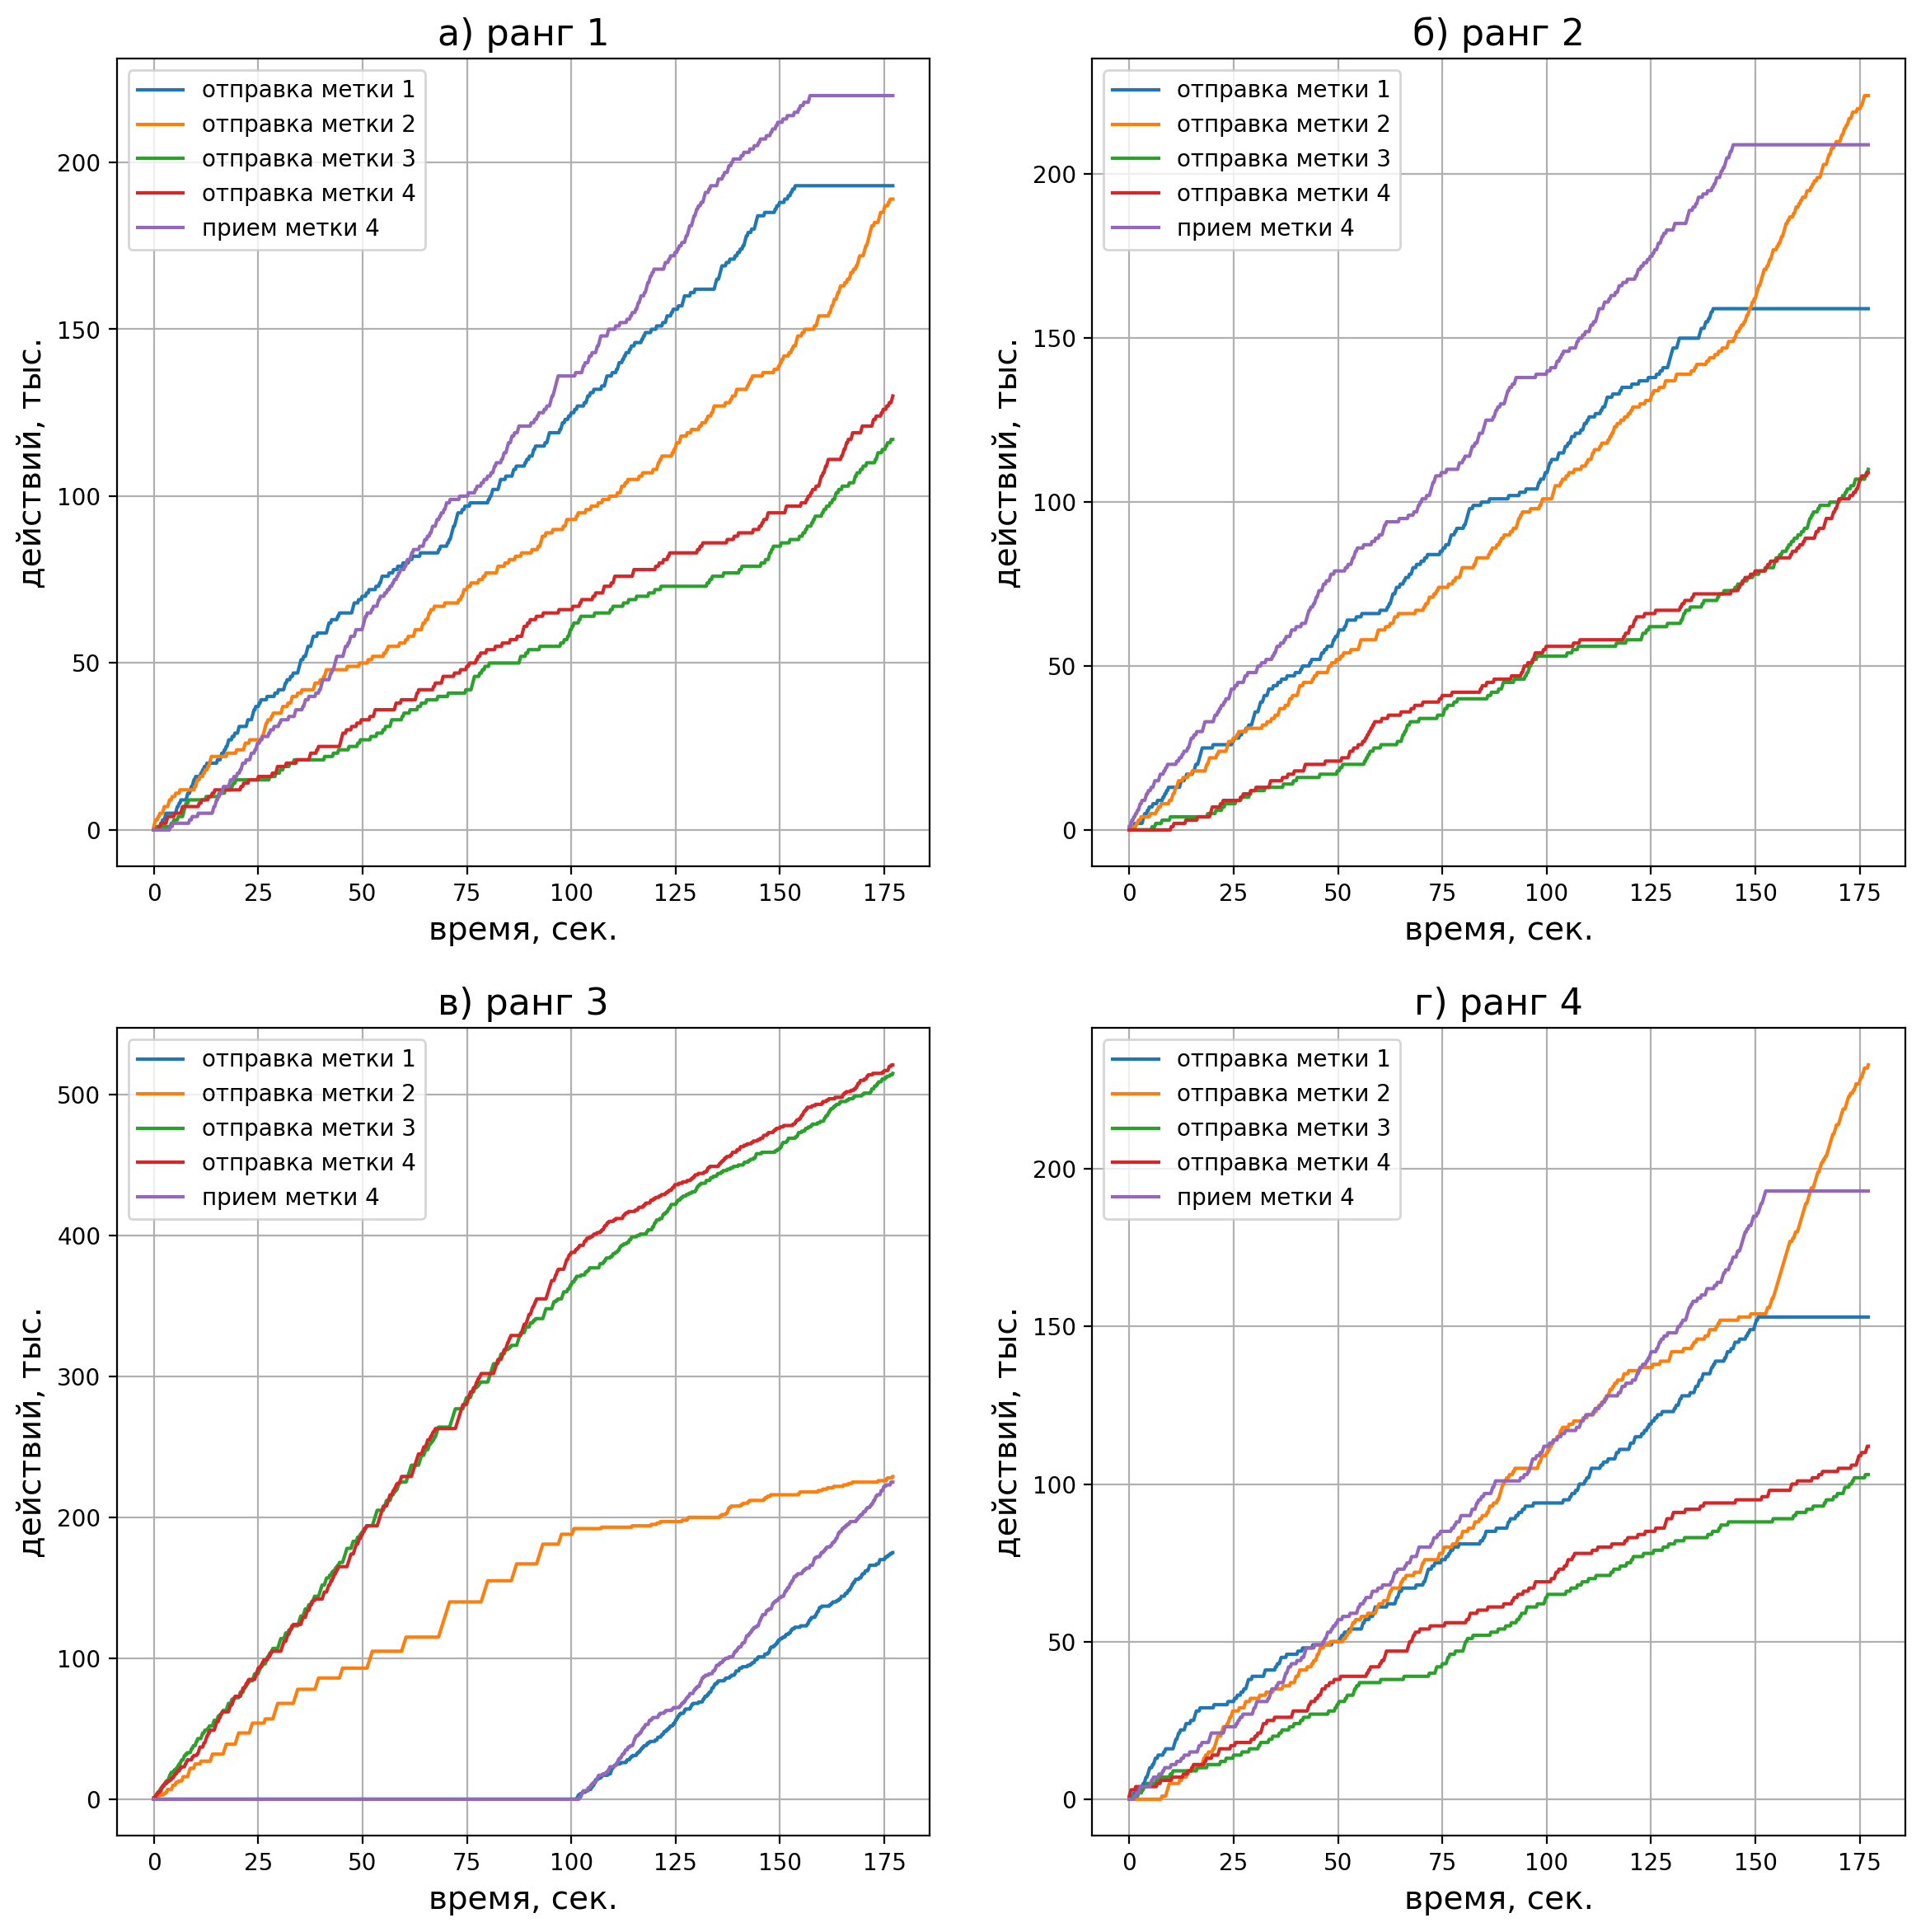

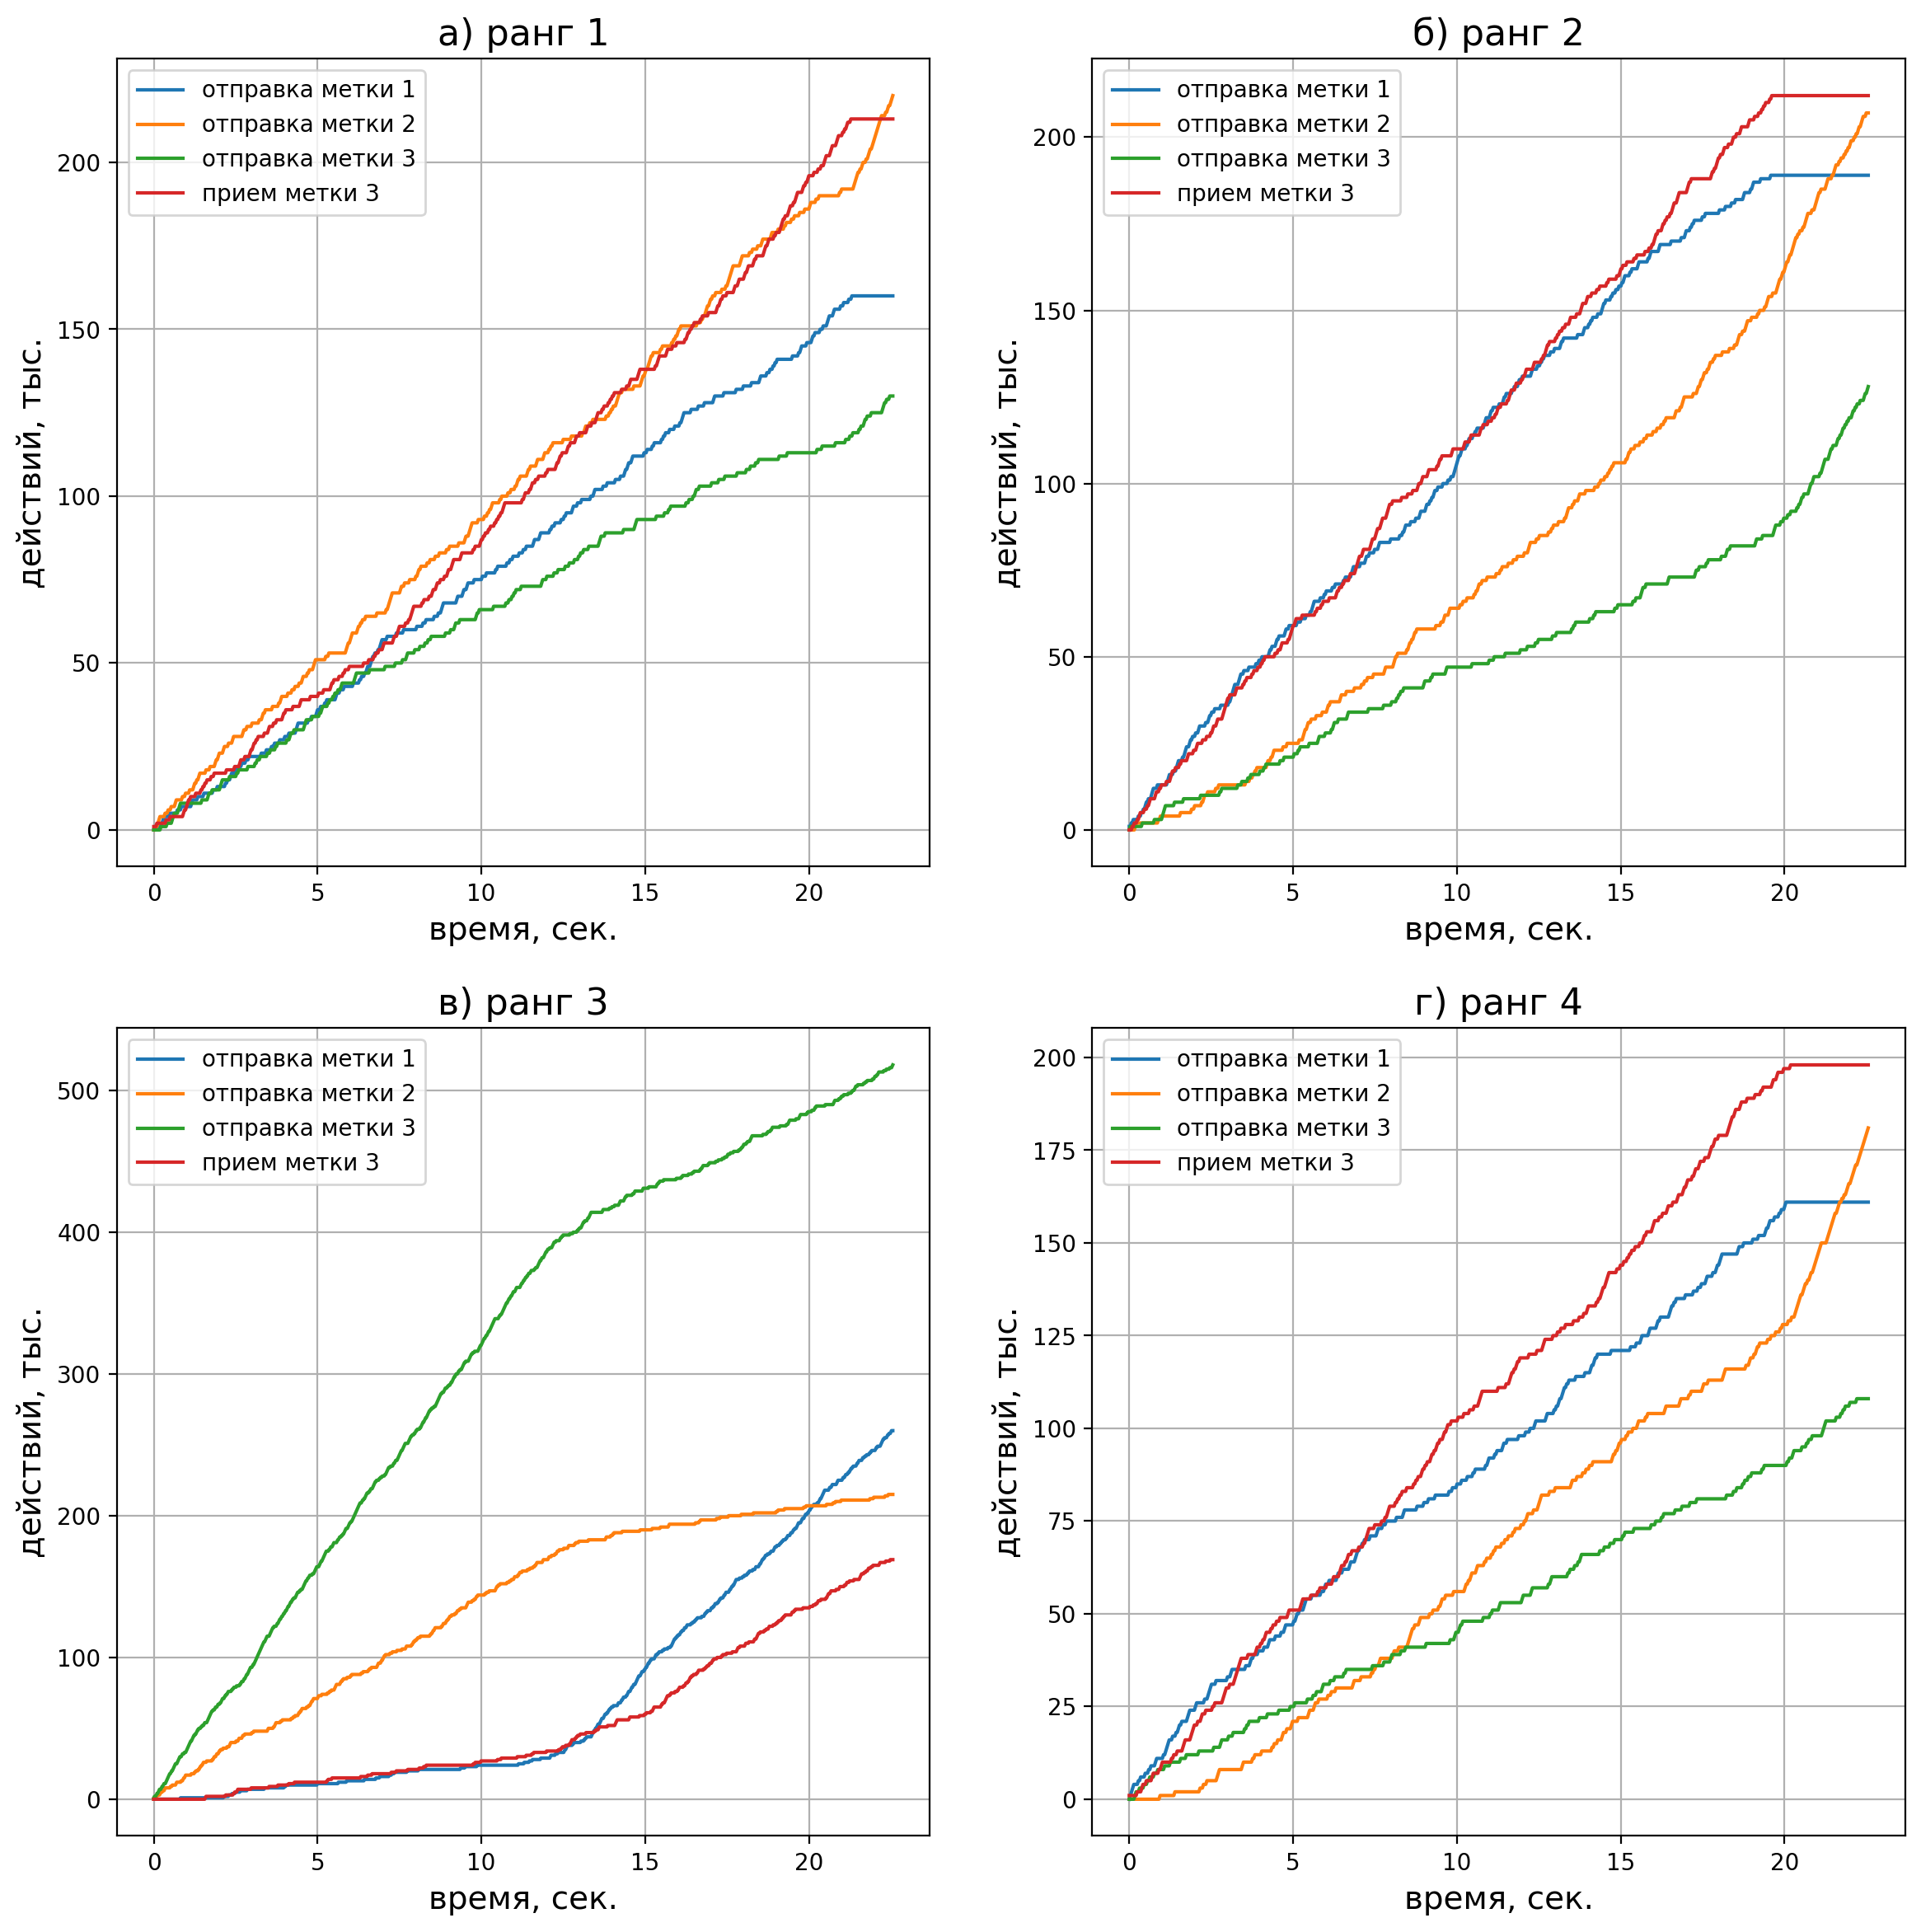

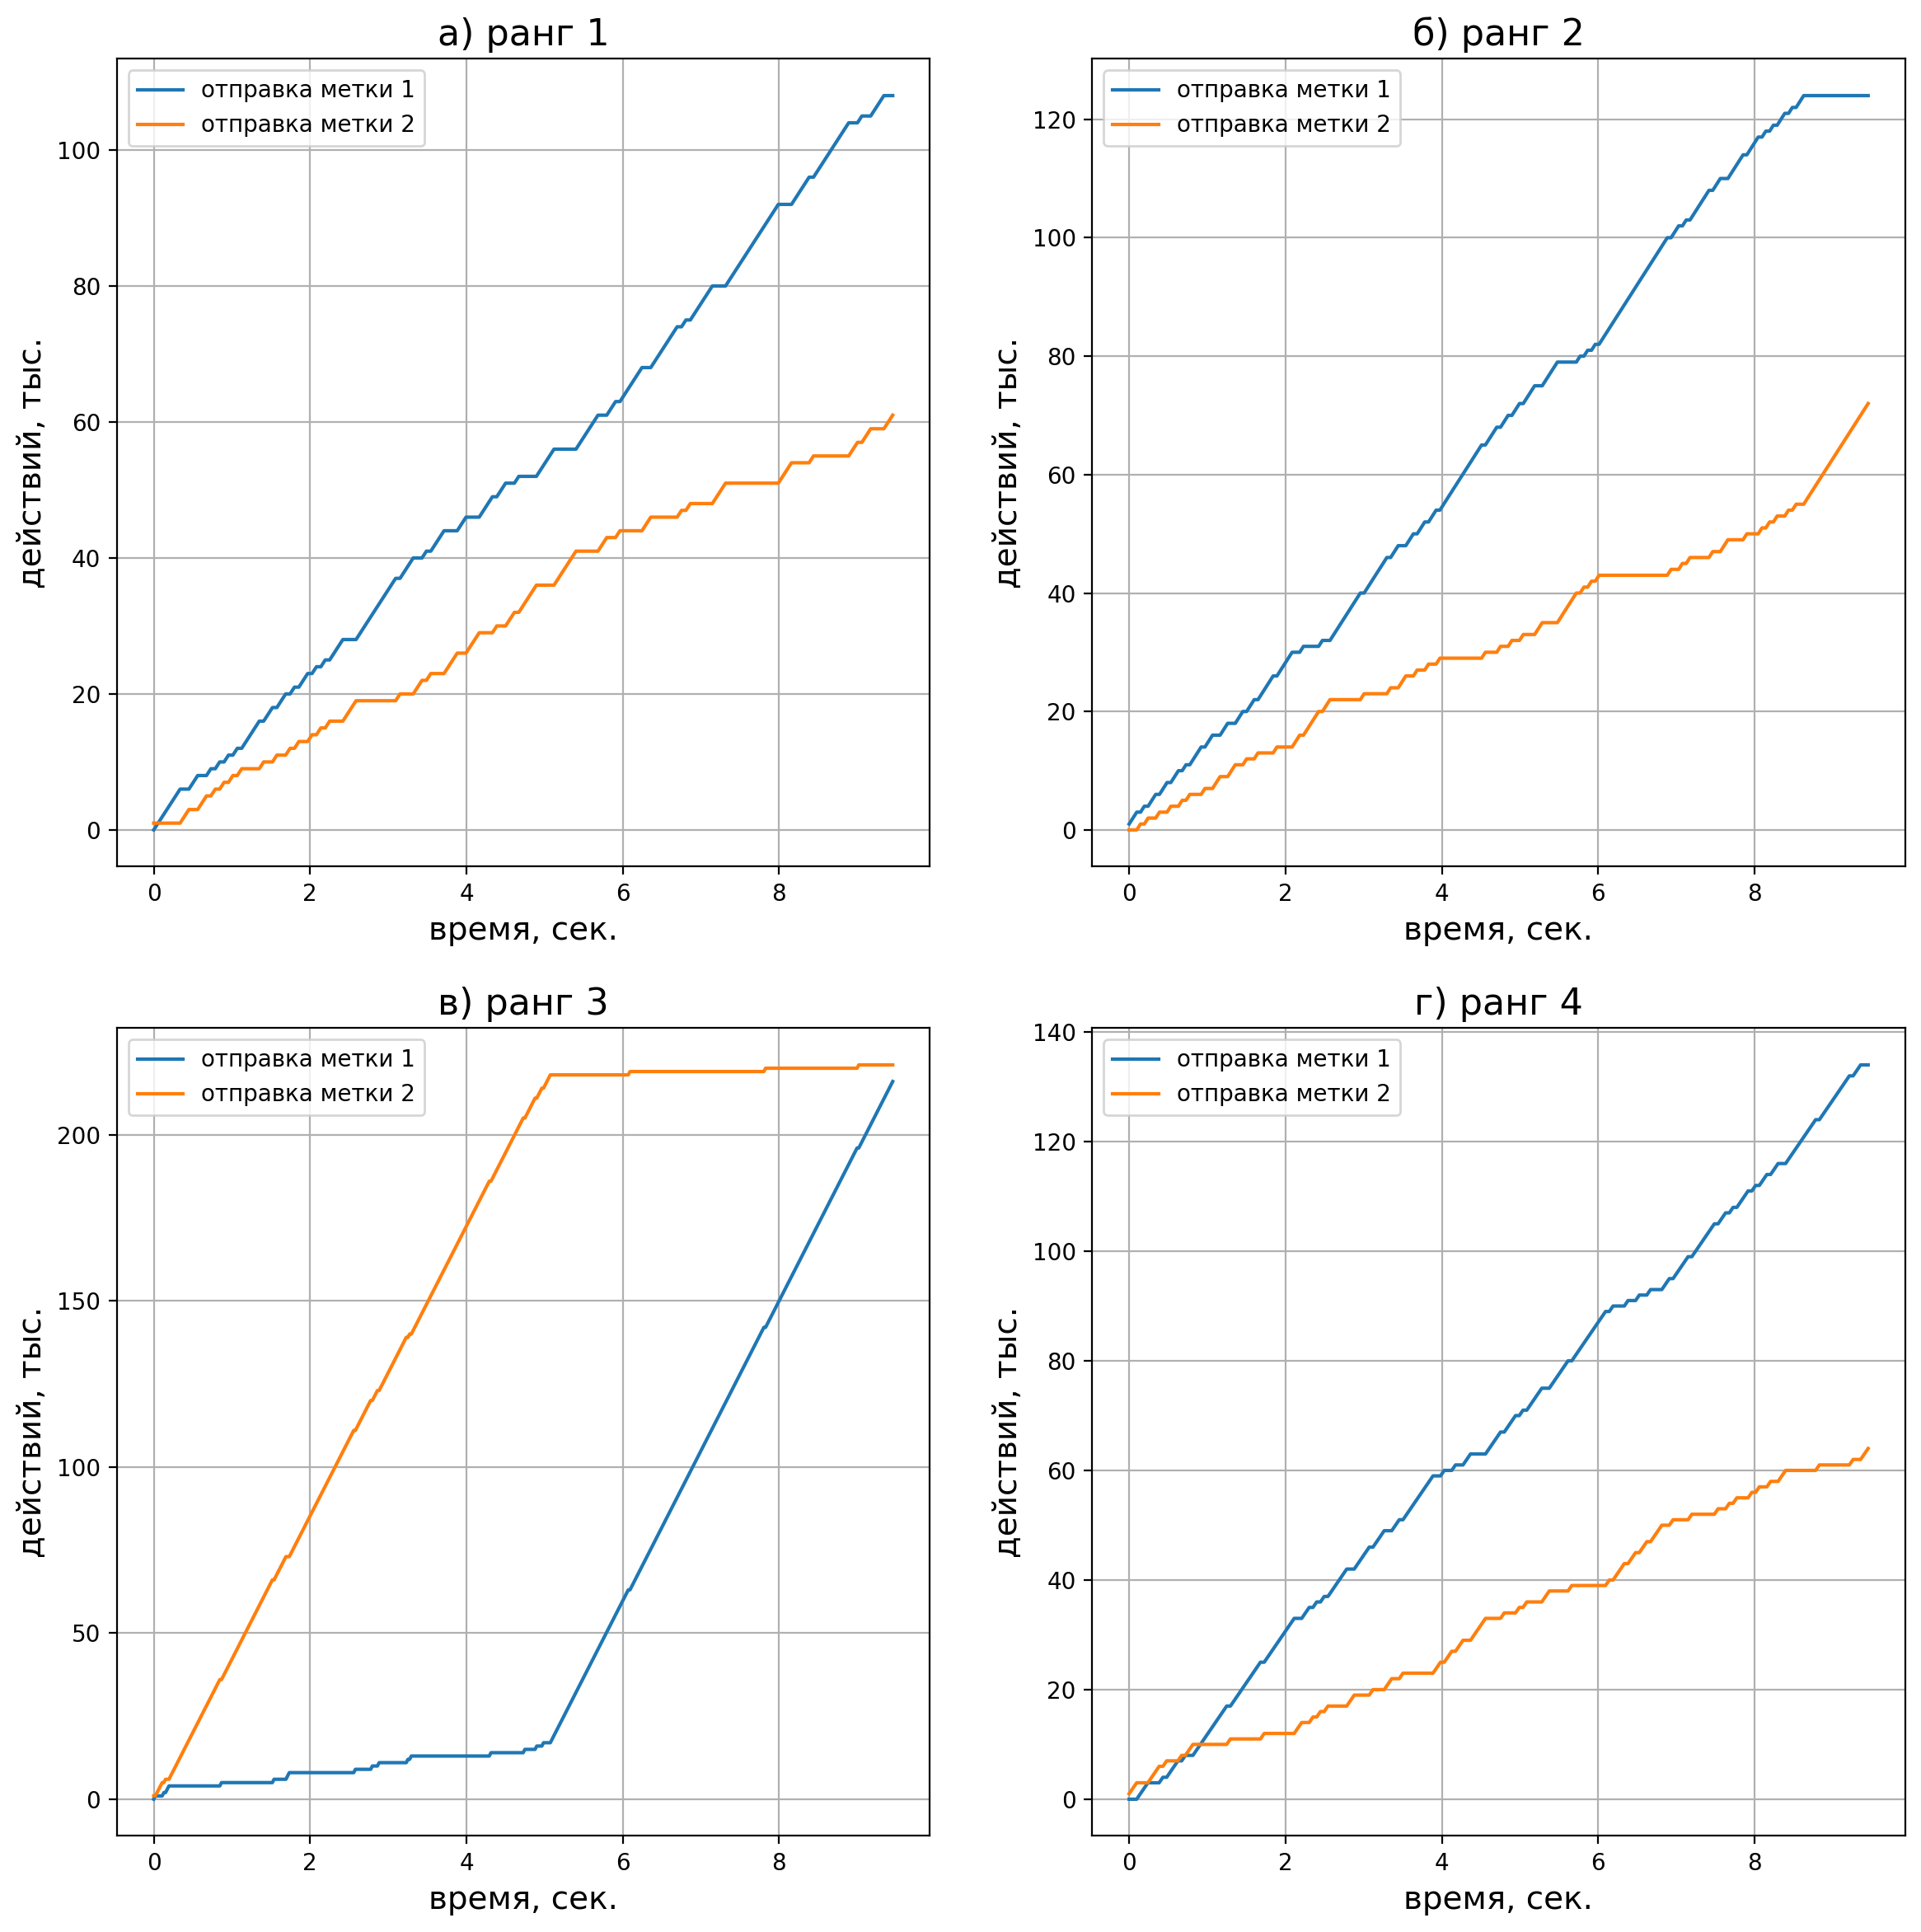

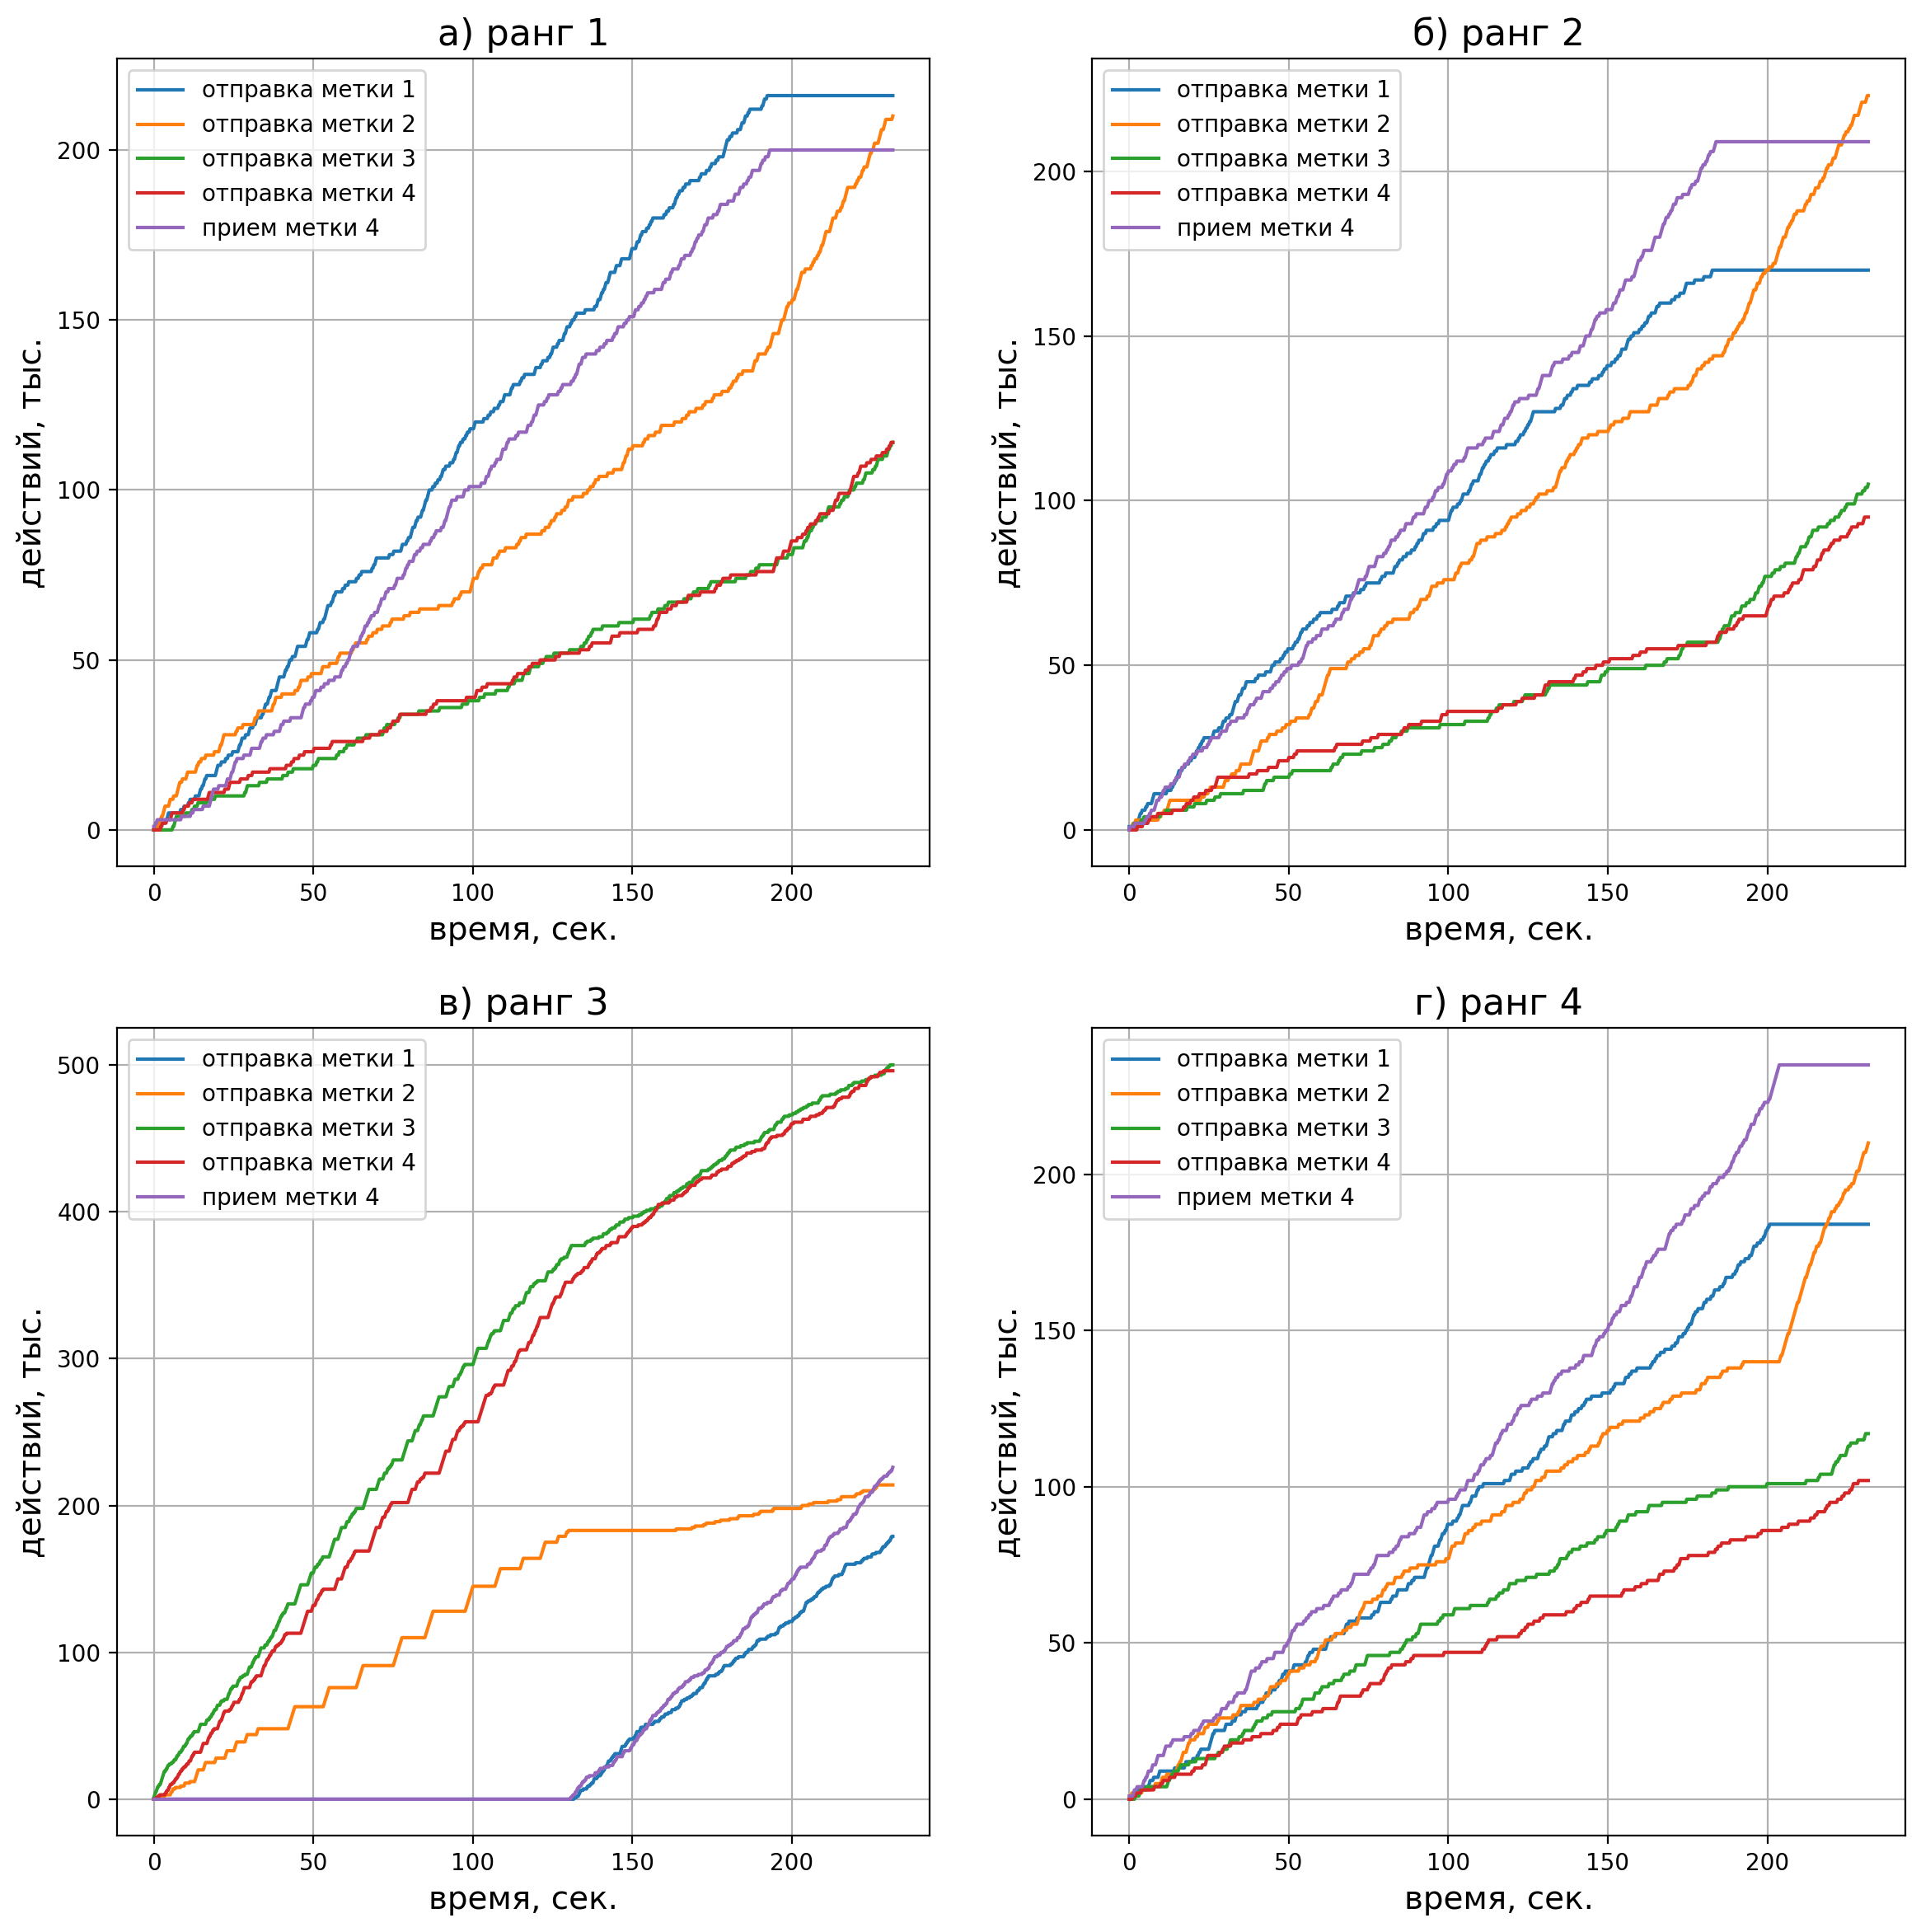

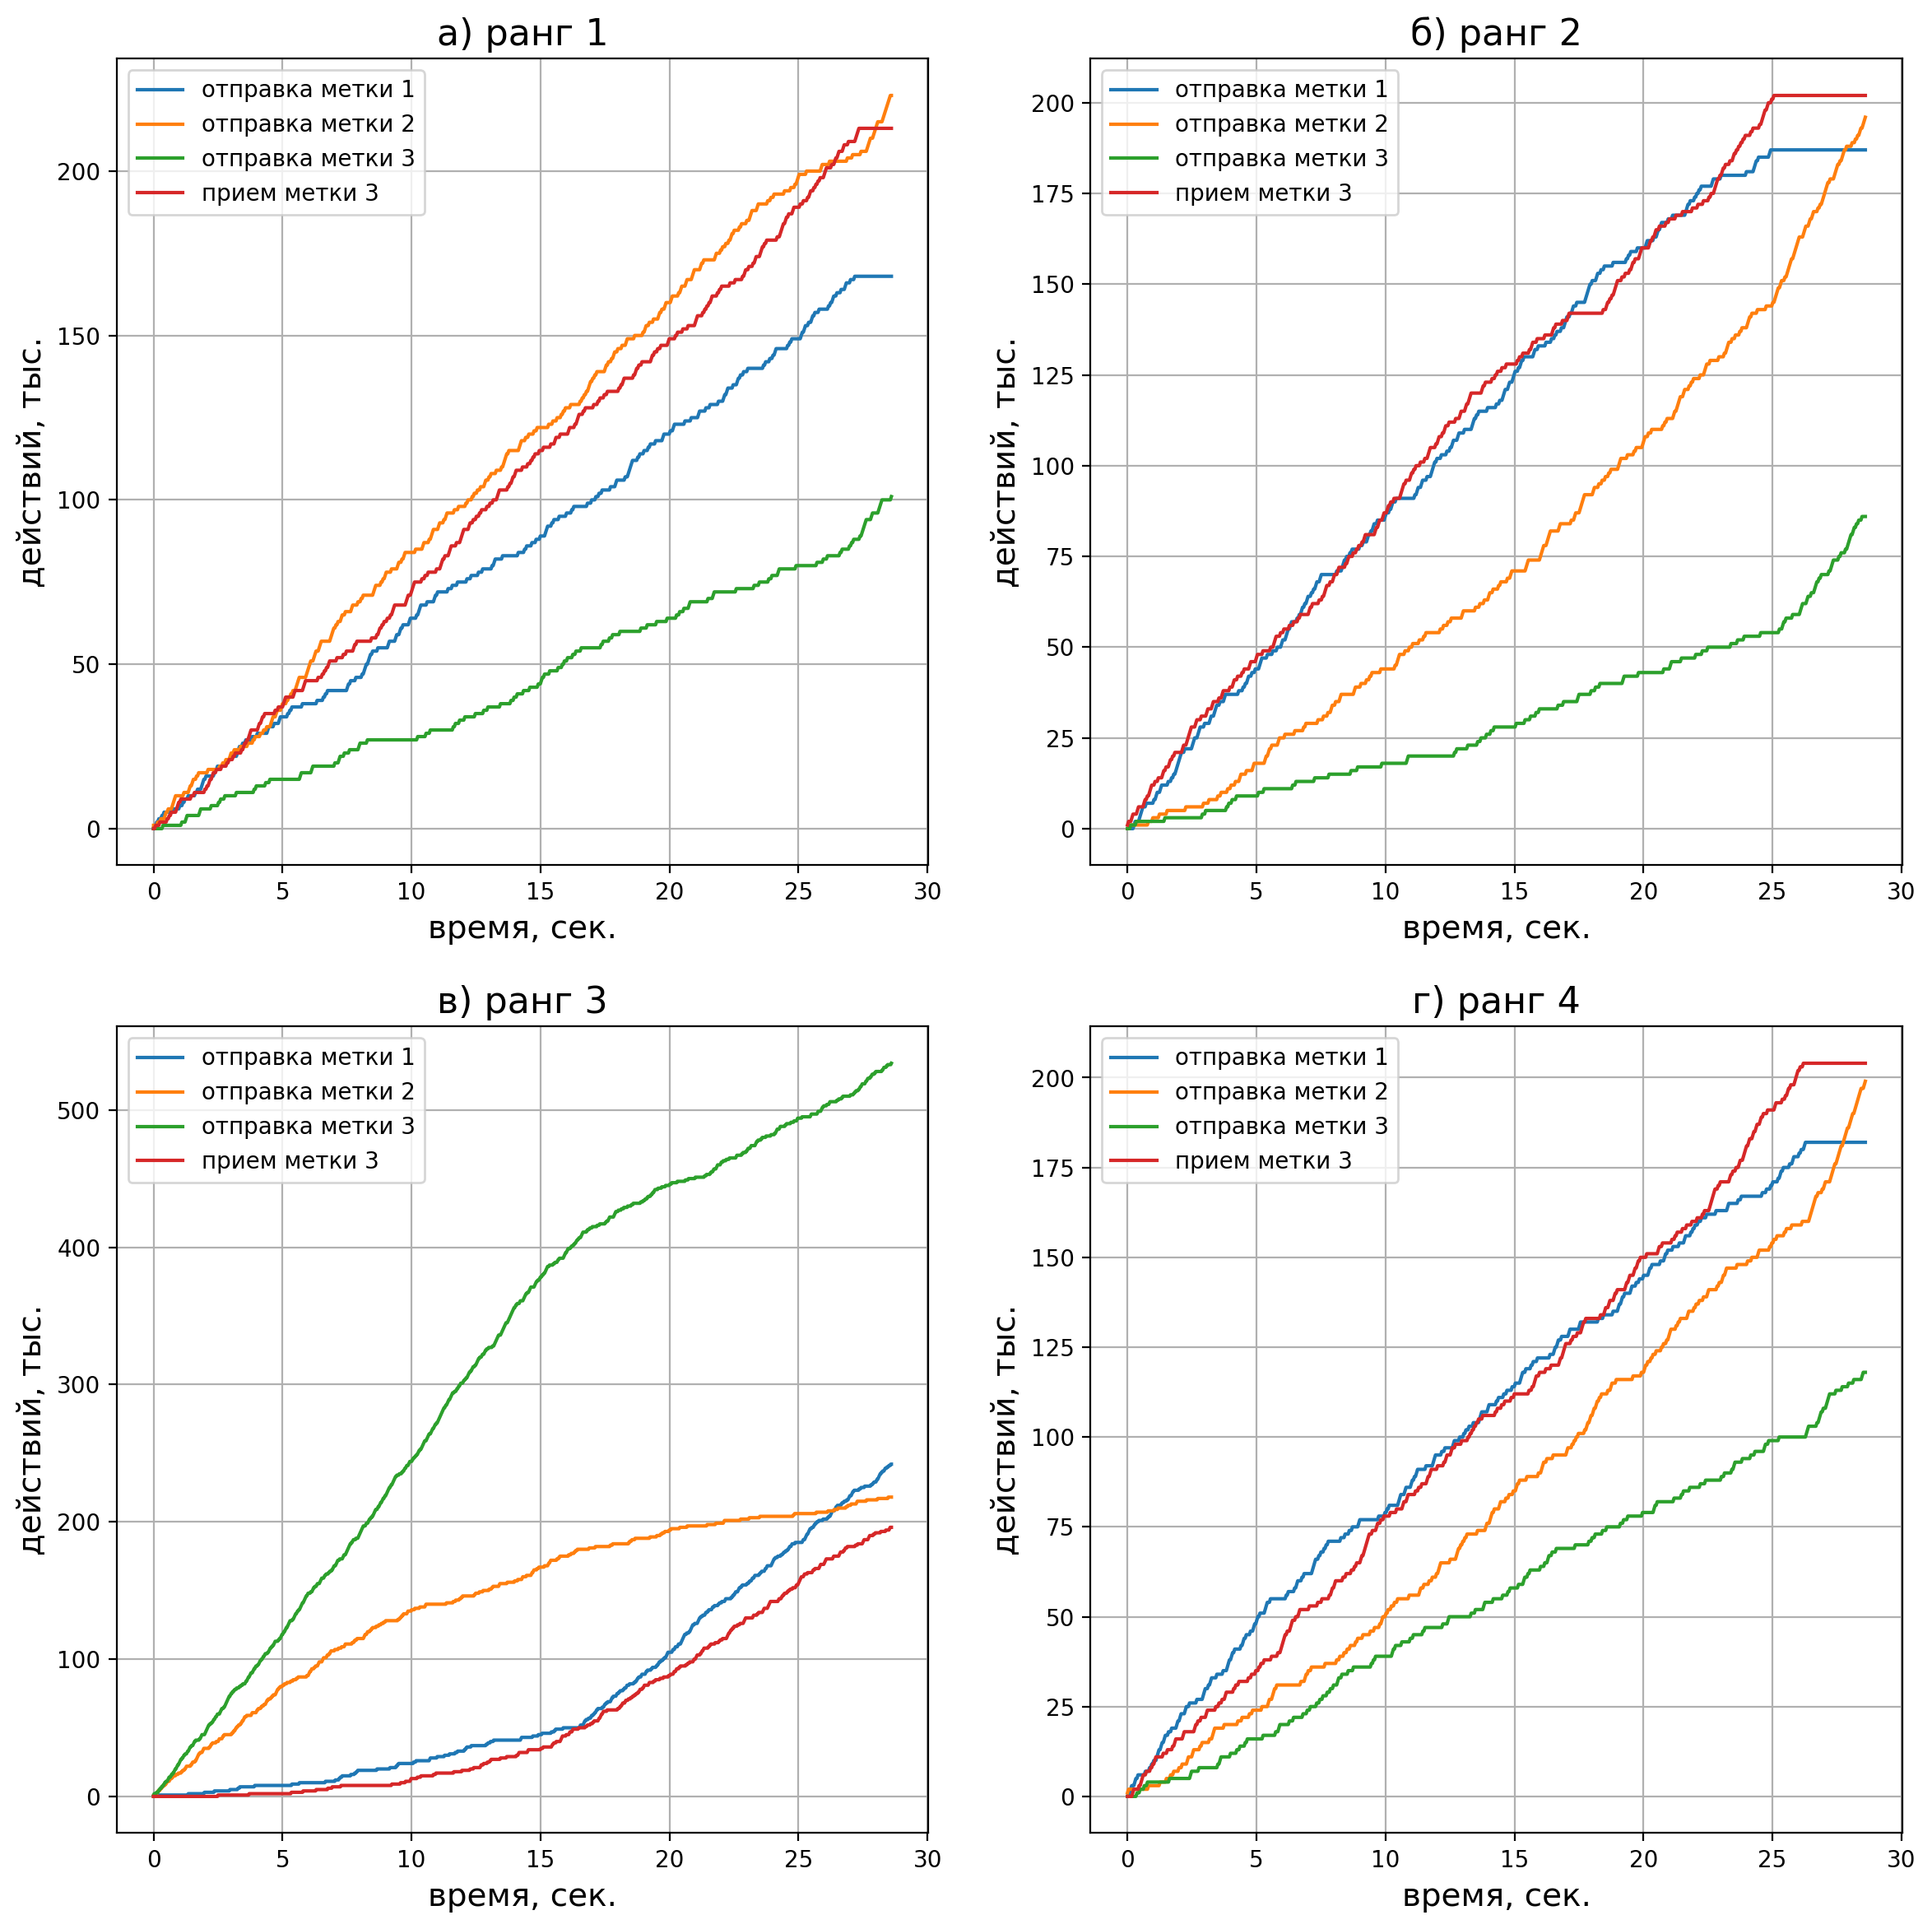

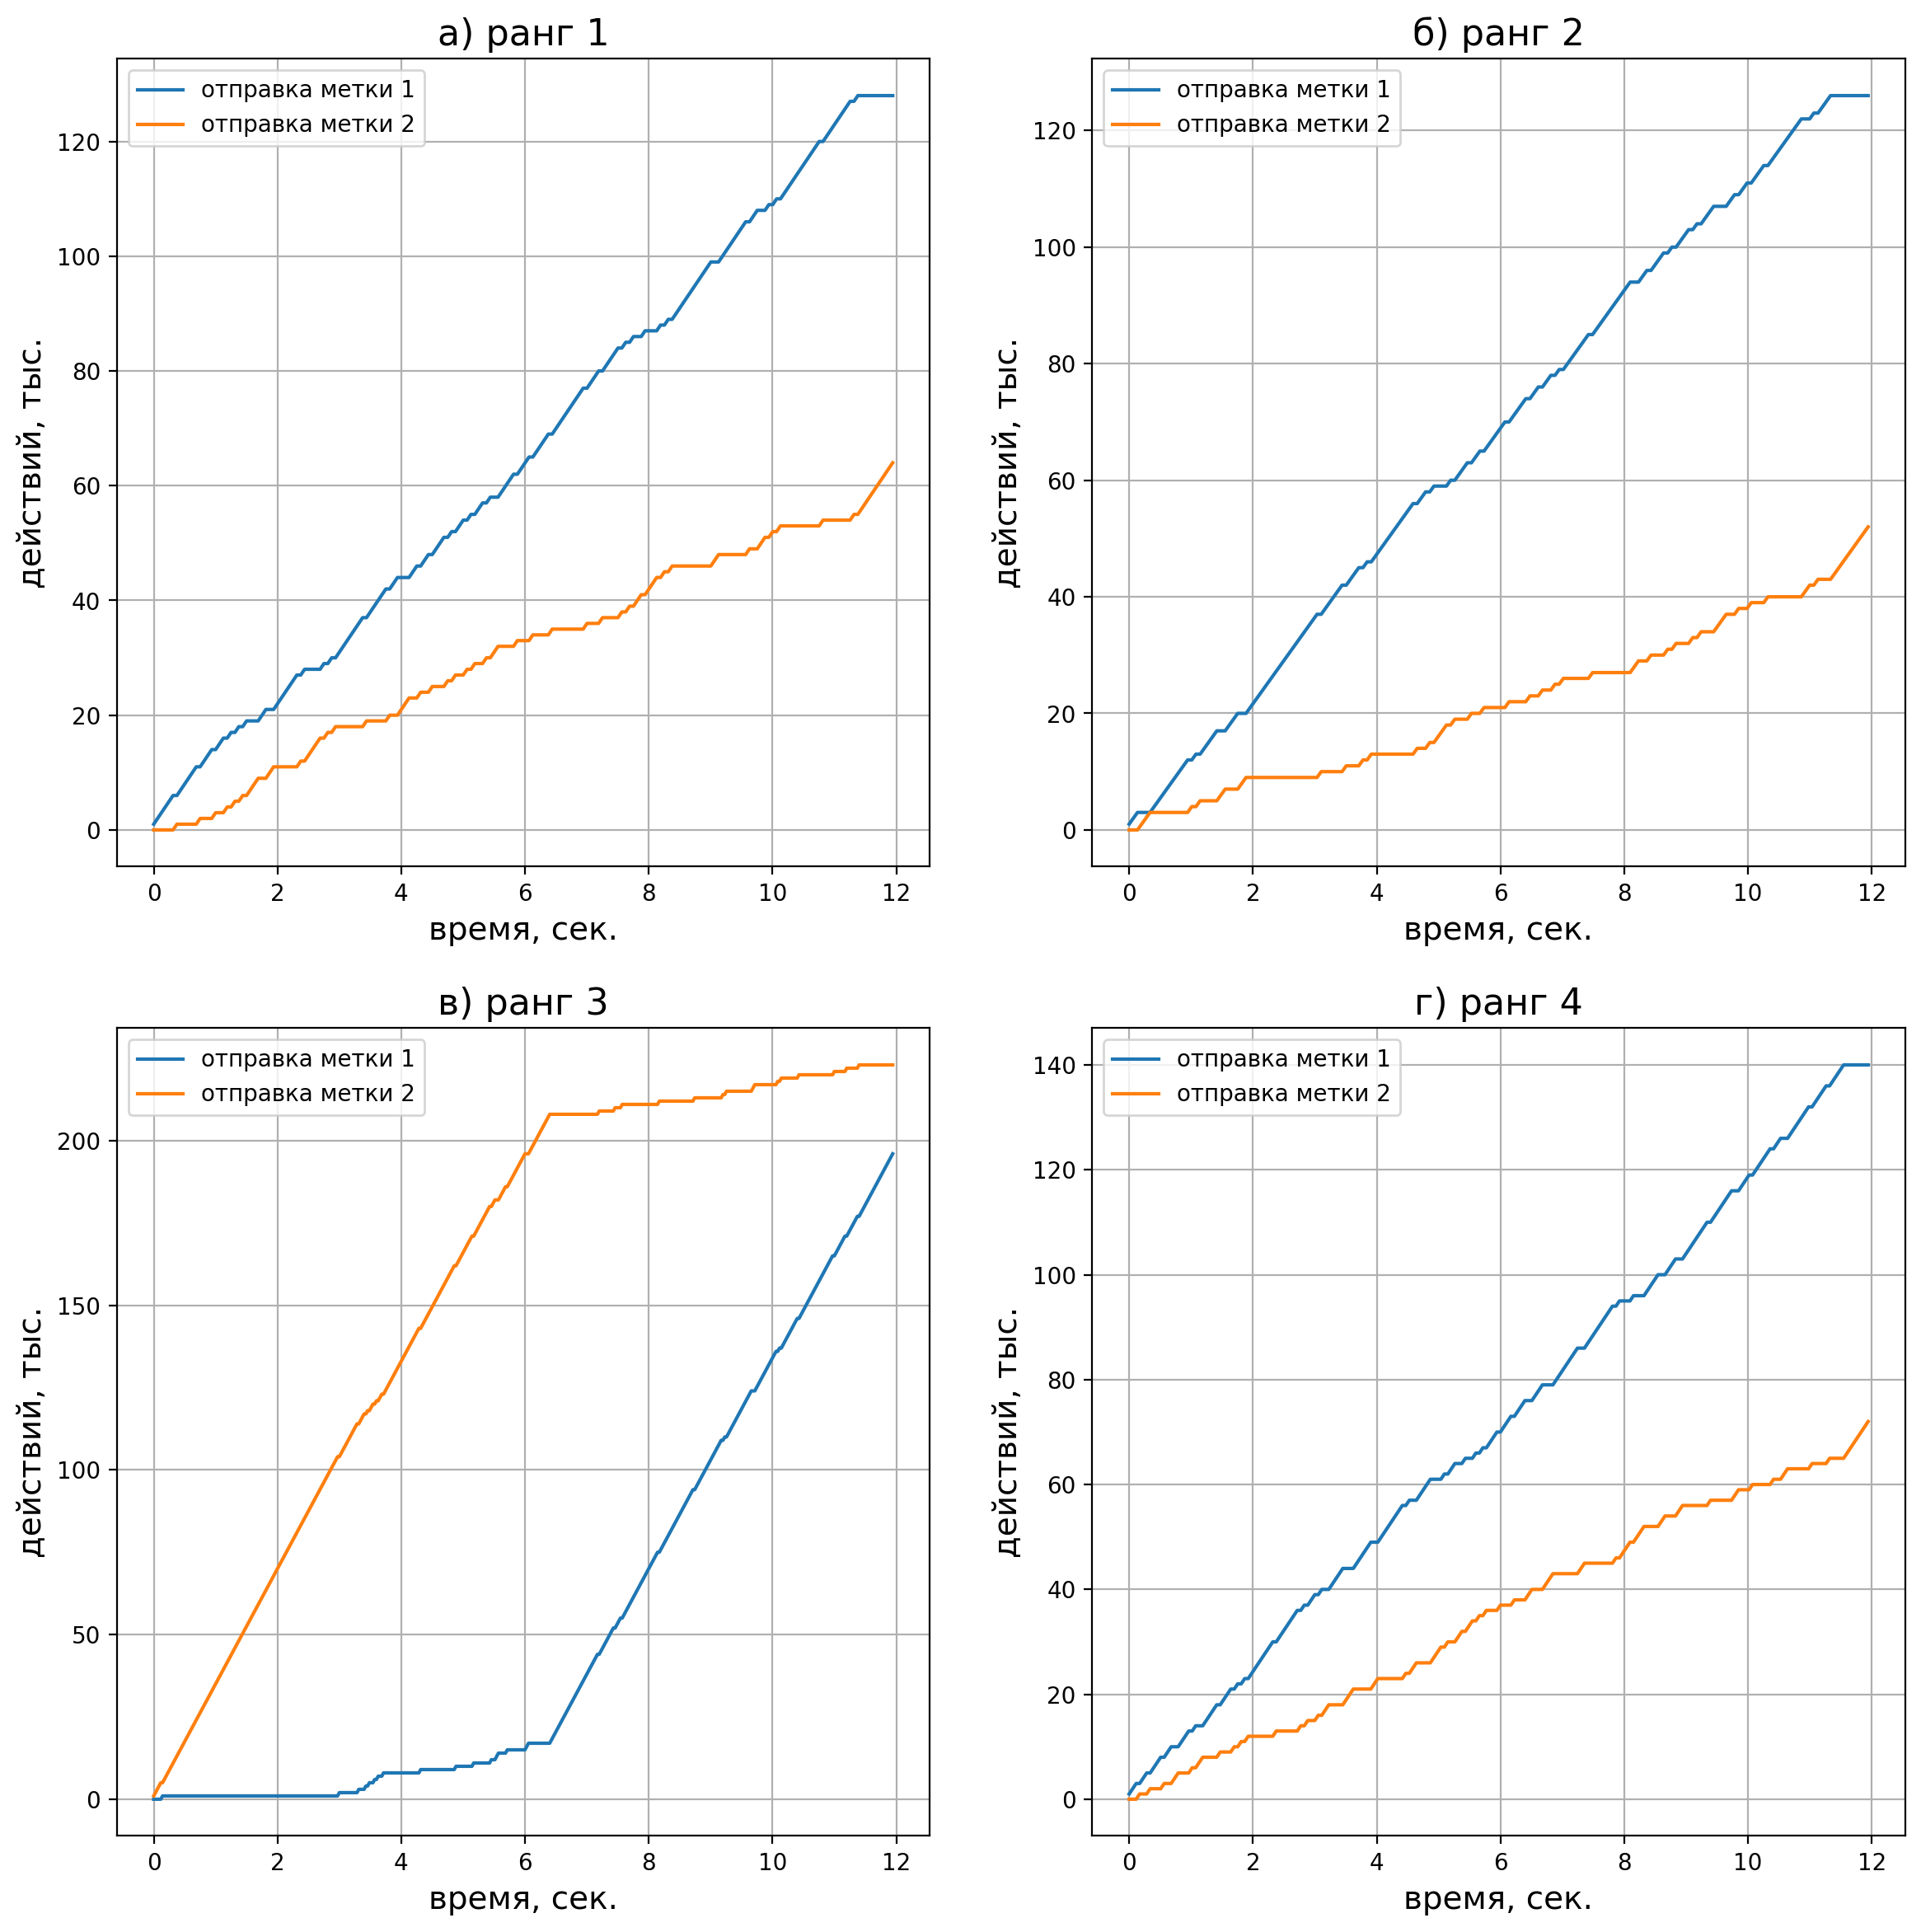

In [131]:
blocks, sum_time = log_parser('log.txt')
print(len(blocks))
log_plot(blocks)

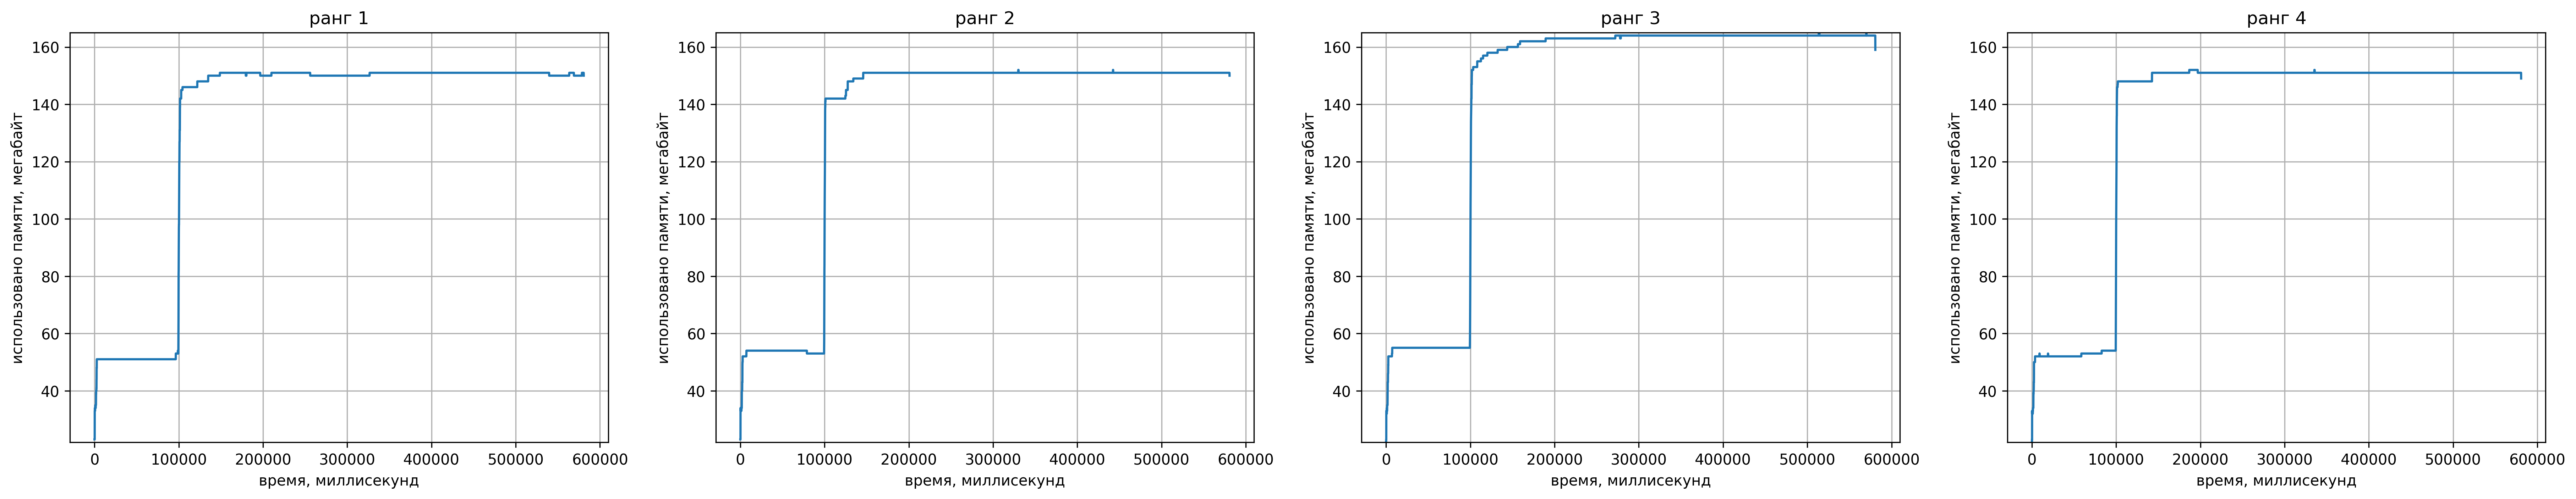

In [132]:
memlog, mem_max, mem_avg = memory_parser("mem.csv")
memory_plot(memlog)
# mem_max, mem_avg
# memlog.head()

# делаем много данных

In [ ]:
# SaintTable = pd.DataFrame(columns = ['name', 'algo', 'mem_max', 'mem_avg', 'total_time', 'iters'])

In [ ]:
# SaintTable

In [19]:
# Gs = ['test']+[f'G{i}' for i in range(0,5)]
Gs = ['G1']
algos = [MODE1]
algo_map = {'algo-mpi-no-dist': 'быстрый алгоритм', 'algo-mpi-basic': 'примитивный алгоритм'}

In [20]:
# u = str(uuid4())[:8]
# u

In [21]:
for name in Gs:
    for algo in algos:
        print('\n\n-----------------------\n\n')
        print(f'{name} <- {algo}')
        try:
            os.remove('mem.csv')
            os.remove('log.txt')
        except FileNotFoundError:
            pass
        
        cmd = f'/usr/bin/go run main.go -mode=find-cc -algo={algo} -file=tests/big/{name}.csv'
        go = subprocess.Popen(cmd.split(),  stdout=subprocess.DEVNULL)
        go.wait()
        time.sleep(2)
        
#         _, mem_max, mem_avg = memory_parser('mem.csv')
#         blocks, time_sum, iters_num = parse_log_simple('log.txt')
#         row = [name, algo_map[algo], mem_max, mem_avg, time_sum, iters_num]
#         print(row)
#         SaintTable.loc[len(SaintTable)] = row
#         SaintTable.to_csv(f'saint_table{u}.csv')
        
        



-----------------------


G1 <- algo-mpi-basic


In [124]:
df = pd.read_csv('saint_table6c16ad07.csv')
df = df.set_index(df['name'])
df = df.drop(df.columns[[0,1]], axis=1)
df['mem_max'] = df['mem_max'].map(int)
df['mem_avg'] = df['mem_avg'].round(1).map(str).map(lambda x: x.replace('.', ','))
df['total_time'] = df['total_time'].round(2).map(str).map(lambda x: x.replace('.', ','))
print(df.to_latex())

\begin{tabular}{llrllr}
\toprule
 & algo & mem_max & mem_avg & total_time & iters \\
name &  &  &  &  &  \\
\midrule
test & примитивный алгоритм & 53 & 52,2 & 7,72 & 37 \\
test & быстрый алгоритм & 56 & 45,4 & 8,35 & 4 \\
test & примитивный алгоритм & 48 & 47,9 & 7,46 & 37 \\
test & быстрый алгоритм & 60 & 44,5 & 8,18 & 4 \\
G0 & примитивный алгоритм & 97 & 68,6 & 169,92 & 86 \\
G0 & быстрый алгоритм & 155 & 101,9 & 96,36 & 4 \\
G1 & примитивный алгоритм & 325 & 116,8 & 851,43 & 83 \\
G1 & быстрый алгоритм & 163 & 120,8 & 616,13 & 4 \\
G2 & примитивный алгоритм & 510 & 181,8 & 1408,77 & 87 \\
G2 & быстрый алгоритм & 163 & 139,1 & 1489,47 & 4 \\
G3 & примитивный алгоритм & 574 & 146,1 & 2477,81 & 97 \\
G3 & быстрый алгоритм & 176 & 151,5 & 2315,18 & 4 \\
\bottomrule
\end{tabular}



In [ ]:
print(df.to_latex())

In [ ]:
process_log('log.txt')
memory_parser('mem.csv')

In [108]:
! ls

 outputs   tools     main                   run.sh
 report    go.mod    main.go                saint_table6c16ad07.csv
 src       go.sum    mem.csv               
 tests     log.txt   report_creator.ipynb  
